Note - to run this notebook, the file "uploadToDBCode" must be present in the same directory as where this notebook is being ran from.

In [1]:
import uploadToDBCode as ds
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from functools import reduce
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sb
import math

Note - all figures correct at the time of writing the report (Week of 20th April). Updated figures are taken every time data is pulled from their relevant websites so it is possible that the figures have changed upon assessment.

# Access data from database

In [ ]:
#pip install statsmodels 

The datadownload function will check to see if all necessary dataframes are uploaded to mongoDB. If they are not then it will create new collections and upload to it. It will then pull the dataframes from it as "mongoDFs" once it is created.

In [2]:
ds.uncleanedDataDownload()

Dataframes already present in database. Dataframe pulling from database initiated.
Dataframes now stored as mongoDFs


The goal of this study is to obtain visualizations of the following -
- case fatality rate (CFR) vs time (for each country)
- Deaths per 100k vs time (for each country)
- Weekly cases vs weekly deaths (for each country)
- Country median age vs fatality rate
- Icu bed density vs fatality rate
- Hospital bed density vs fatality rate
- Country weekly fatality rate -

In particular, we shall examine how predetermined factors such as the number of both hospital and ICU beds per person and the median age of a country's population impact on a country's case fatality rate.

# Data viewing

We shall start with viewing the initial states of the data sets uploaded. We access the data sets used via the code below 

In [54]:
hospitalICURatesEurope=ds.mongoDFs[0]
worldWideCasesAndDeaths=ds.mongoDFs[1]
hospitalBedDensity=ds.mongoDFs[2]
icuBedDensity=ds.mongoDFs[3]
medianAge=ds.mongoDFs[4]

In [ ]:
hospitalBedDensity

In [ ]:
hospitalICURatesEurope

In [ ]:
worldWideCasesAndDeaths

In [ ]:
icuBedDensity

In [55]:
medianAge

Country  Median  Median (Male)  Median (Female)
0                       Monaco    53.1           51.7             54.5
1                        Japan    47.3           46.0             48.7
2                      Germany    47.1           46.0             48.2
3    Saint Pierre And Miquelon    46.5           46.0             47.0
4                        Italy    45.5           44.4             46.5
..                         ...     ...            ...              ...
216                     Malawi    16.5           16.4             16.7
217                     Angola    15.9           15.4             16.3
218                       Mali    15.8           15.1             16.4
219                     Uganda    15.8           15.7             15.9
220                      Niger    15.4           15.3             15.5

[221 rows x 4 columns]

# Data cleaning

### Manipulation of hospital and ICU occupancy stats table

A number of issues stick out upon viewing the table of hospital and ICU occupancy. The source and url columns appear irrelevant to our study and should be removed. There is a time dependency here of the "year_week". This is of a similar format to the "year_week" column in the worldWideCovidCasesAndDeaths table. Hence we can remove the "date" column here

Furthermore, it is evident that there is many unnecessarily repeated column entries. From the example shown below of Ireland, each country has entries for daily hospital occupancy, daily ICU occupancy as well as weekly new hospital admissions per 100k and weekly new icu admissions per 100k. This makes viewing and analysing the table difficult. An improved table would see adding these unique indicator values as columns in the table. 
This would have the benefit of reducing the number of rows by a factor of 4 as well making the table more readable

In [ ]:
hospitalICURatesEurope["indicator"].unique()

In [ ]:
hospitalICURatesEurope[hospitalICURatesEurope["country"]=="Ireland"]

Furthermore, after investigation it was noticed that very few countries had data provided for the weekly ICU admissions (only 15 countries) whereas 19 countries had data for their daily ICU admissions. Thus the decision was made that it would be best to use the daily values and group them weekly, and to ignore the given values for weekly new hospital icu admissions. To group them weekly, it was necessary to convert them to datetime (timeseries) format, before once again converting them back to a dataframe.

In [ ]:
tmpICUOcDaily=len(hospitalICURatesEurope[hospitalICURatesEurope["indicator"]=="Daily ICU occupancy"]["country"].unique())
tmpICUOcDaily

In [ ]:
tmpICUOcWeekly=len(hospitalICURatesEurope[hospitalICURatesEurope["indicator"]=="Weekly new ICU admissions per 100k"]["country"].unique())
tmpICUOcWeekly

In [ ]:
dateTimeDFs=[]
hTest=[]
newdfs=[]
vals=[]
newvals=[]
p=[]
hospitalICURatesEurope=ds.mongoDFs[0]

#Drop unnecessary columns
hospitalICURatesEurope = hospitalICURatesEurope.drop(["source","url"],axis=1)
hospitalICURatesEurope=hospitalICURatesEurope.rename(columns={"country":"Country"})

#find unique indiators
unqVals=hospitalICURatesEurope['indicator'].unique()

for i in unqVals:
    #add new columns with the unique indicators
    vals.append((hospitalICURatesEurope[hospitalICURatesEurope['indicator']==i]).rename(columns={"value":i}))

for j in vals:
    #remove the indicator column
    j=((j.drop(["indicator"],axis=1)))
    hTest.append(j)
dailyValues=[hTest[0],hTest[1]]

#Grouping the daily value in terms of weeks
for j in dailyValues:
    #The "-pd.to_timedelta" factor here is used to format the dates such that the values of the week beginning are shown (and not the week ending)
    #The dataframe must first be converted to a datetime format in order to use the pandas "Grouper" and groupby functions
    j["date"]= pd.to_datetime(j["date"]) - pd.to_timedelta(7, unit='d')
    #Set date beginning on a monday
    p.append(j.groupby([pd.Grouper(key='date', freq='W-MON'), "Country"])[j.columns[3]].sum())

#Creating 2 seperate dataframes for each indicator value (daily hospital oc and daily icu oc)
for i in p:
    newdfs.append(pd.DataFrame(i))

#Joining the 2 seperate dataframes back
hospitalStats = pd.merge(newdfs[0], newdfs[1],  how='left', left_on=['date','Country'], right_on = ['date','Country'])

hospitalStats=hospitalStats.rename(columns={"Daily hospital occupancy":"Aggregate weekly hosp occupancy","Daily ICU occupancy":"Aggregate weekly ICU occupancy"})
hospitalStats["7 day rolling avg hosp occupancy"]=hospitalStats["Aggregate weekly hosp occupancy"]/7
hospitalStats["7 day rolling avg ICU occupancy"]=hospitalStats["Aggregate weekly ICU occupancy"]/7
hospitalStats=hospitalStats.drop(["Aggregate weekly hosp occupancy","Aggregate weekly ICU occupancy"], axis=1)

In [ ]:
hospitalStats

This table is much easier to read. Two areas requiring modification however are the "NaN" values in the "Weekly ICU occupancy" and the fact that the date is used as the key for the dataframe, hence there is no longer a seperate column for displaying the year and week which will be necessary later for joining tables.

In [ ]:
#Taking the key and creating a temporary column of the year and week
hospitalStats["temp_date"]=(hospitalStats.index.get_level_values('date'))
sr=hospitalStats["temp_date"]   #(df.index.get_level_values('date'))
r = pd.to_datetime(sr)
#converting the format into year-week format
year_week = r.dt.strftime('%Y-%V')
hospitalStats["year_week"]=year_week
hospitalStats=hospitalStats.drop(["temp_date"],axis=1)
hospitalStats.dropna()

In [ ]:
#hospitalStats[hospitalStats["Country"]=="Ireland"]
#hospitalStats[hospitalStats.index.get_level_values('Country')=="Ireland"]

After manipulation, we now have a much simpler table to read which shall be utilised in time.

### Manipulating worldWideCasesAndDeaths table

Now for worldwide cases and deaths. As can be seen, again there are unnecessary columns present (source, country_code, continent etc).

In [ ]:
ds.mongoDFs[1].head()

As can be seen, there is a lot of unnecessary data here, in both rows and columns. So our task is to clean this. Columns such as source, continent etc must be removed. But it will also help our cause to eliminate the column "indicator" and add columns such as "cumulative case count" etc instead of the existing columns of case count per indicator. This will both help to minimize our data but also help us to better visualise what is going on.
This table has 2 values for each country (one for cases and deaths). To make this clearer, the "cumulative count" and "14 day rate" will be relabelled to reflect the indicator used, which will also have the effect of halfing the number of rows.

Furthermore, the data is currently sorted alphabetically. We shall need to convert this to be sorted chronologically by year_week. It is also preferrable to view the cases in terms of cases and deaths per capita, so this column will be added.

In [ ]:
worldWideCasesAndDeaths=ds.mongoDFs[1]
#Dropping unnecessary columns
worldWideCasesAndDeaths=worldWideCasesAndDeaths.drop(["country_code","source","continent"],axis=1)
worldWideCasesAndDeaths=worldWideCasesAndDeaths.rename(columns={"country":"Country"})
#worldWideCasesAndDeaths

#Creating a temp dataframe of worldWideCasesAndDeaths to reflect both cases and deaths
WW_test=worldWideCasesAndDeaths[(worldWideCasesAndDeaths["indicator"] == "cases")]
WW_test=WW_test.rename(columns={"cumulative_count":"cum_cases","rate_14_day":"14dCR","weekly_count":"wkly cases"})
WW_test=WW_test.drop(["indicator"],axis=1)

WW_test2=worldWideCasesAndDeaths[(worldWideCasesAndDeaths["indicator"] == "deaths")]
WW_test2=WW_test2.rename(columns={"cumulative_count":"cum_deaths","rate_14_day":"14dDR","weekly_count":"wkly deaths"})
WW_test2=WW_test2.drop(["indicator","population"],axis=1)

#Merging the 2 dataframes
worldWideCasesAndDeaths= pd.merge(WW_test, WW_test2,  how='left', left_on=['Country',"year_week"], right_on = ['Country',"year_week"])
#WW_test

#Sorting data chronologically by year_week and adding a column to reflect weekly cases per population.
WWCAD=worldWideCasesAndDeaths.sort_values(by=['year_week'])
WWCAD["wkly cases per 100k"]=((WWCAD["wkly cases"])*100000)/(WWCAD["population"])

In [ ]:
WWCAD

The new format is much more readable and shall help our querying and joining of tables in future.

### Manipulating dataframe of ICU bed density per country

In [ ]:
ds.mongoDFs[3].head()

Here we are only concerned about the ICU and IMCU beds per capita for each country so all other columns shall be dropped.

In [56]:
icuBedDensity=ds.mongoDFs[3]
icuBedDensity
icuBedDensity=icuBedDensity.drop(["Acute care bedsa","Intermediate care (IMCU) beds","Intensive care (ICU) beds",
                                 "Critical care beds","ICU beds as % of acute care beds","GDP ($million)/ICU beds","Acute care beds/100,000 population"], axis=1)
icuBedDensity=icuBedDensity.rename(columns={"Unnamed: 0":"Country"})
icuBedDensity

Country  ICU and IMCU beds/100,000 population
0           Andorra                                   7.1
1           Austria                                  21.8
2           Belgium                                  15.9
3          Bulgaria                                  12.2
4           Croatia                                  14.7
5            Cyprus                                  11.4
6    Czech Republic                                  11.6
7           Denmark                                   6.7
8           Estonia                                  14.6
9           Finland                                   6.1
10           France                                  11.6
11          Germany                                  29.2
12           Greece                                   6.0
13          Hungary                                  13.8
14          Iceland                                   9.1
15          Ireland                                   6.5
16            Italy                                  12.5
17           Latvia                                   9.7
18        Lithuania                                  15.5
19       Luxembourg                                  24.8
20  The Netherlands                                   6.4
21           Norway                                   8.0
22           Poland                                   6.9
23         Portugal                                   4.2
24          Romania                                  21.4
25         Slovakia                                   9.2
26         Slovenia                                   6.4
27            Spain                                   9.7
28           Sweden                                   5.8
29      Switzerland                                  11.0
30               UK                                   6.6

### Manipulating dataframe of Median age per country

In [ ]:
ds.mongoDFs[4].head()

As the only dataframe with information regarding gender is the "medianAge", we shall remove the columns referencing gender here as they provide no further information.

In [57]:
medianAge=ds.mongoDFs[4]
medianAge=medianAge.rename(columns={"Median":"Median Age"})
medianAge=medianAge.drop(["Median (Male)","Median (Female)"],axis=1)
medianAge

Country  Median Age
0                       Monaco        53.1
1                        Japan        47.3
2                      Germany        47.1
3    Saint Pierre And Miquelon        46.5
4                        Italy        45.5
..                         ...         ...
216                     Malawi        16.5
217                     Angola        15.9
218                       Mali        15.8
219                     Uganda        15.8
220                      Niger        15.4

[221 rows x 2 columns]

### Manipulation of hospital bed density per country dataframe

In [ ]:
ds.mongoDFs[2].head(10)

The dataframe of hospitalBedDensity looks problematic as it shows several values for countries over a range of years. We shall select only the most recent value of hospitalBedDensity for each country. We shall compute this using the "Groupby" function. Furthermore we shall drop unneccessary columns such as "YEAR", "GHO" etc.

In [58]:
hospitalBedDensity=ds.mongoDFs[2]

hospitalBedDensity = hospitalBedDensity.groupby('Country').max("YEAR")
#hospitalBedDensity["Hosp beds per 100k"]=hospitalBedDensity["Display"]*10
hospitalBedDensity["Hosp beds per 100k"]=(hospitalBedDensity["Display"].astype(float))*10
hospitalBedDensity=hospitalBedDensity.drop(["YEAR","GHO","PUBLISHSTATE","Numeric","Display"], axis=1)

hospitalBedDensity


Hosp beds per 100k
Country                                               
Afghanistan                                       53.0
Albania                                          326.0
Algeria                                          190.0
Angola                                            80.0
Antigua and Barbuda                              361.0
...                                                ...
Venezuela (Bolivarian Republic of)                93.0
Viet Nam                                         318.0
Yemen                                             72.0
Zambia                                           200.0
Zimbabwe                                         300.0

[178 rows x 1 columns]

### Joining time-independant tables

In [59]:
TIdfs=hospitalBedDensity,medianAge,icuBedDensity
staticTable = reduce(lambda left,right: pd.merge(left,right,on='Country'), TIdfs)
staticTable

Country  Hosp beds per 100k  Median Age  \
0       Austria               795.0        44.0   
1       Belgium               672.0        41.4   
2      Bulgaria               745.0        42.7   
3       Croatia               615.0        43.0   
4        Cyprus               452.0        36.8   
5       Denmark               429.0        42.2   
6       Estonia               704.0        42.7   
7       Finland               754.0        42.5   
8        France               797.0        41.4   
9       Germany               912.0        47.1   
10       Greece               493.0        44.5   
11      Hungary               816.0        42.3   
12      Iceland               412.0        36.5   
13      Ireland               613.0        36.8   
14        Italy               471.0        45.5   
15       Latvia               877.0        43.6   
16    Lithuania               883.0        43.7   
17   Luxembourg               639.0        39.3   
18       Norway               525.0        39.2   
19       Poland               668.0        40.7   
20     Portugal               371.0        42.2   
21      Romania               774.0        41.1   
22     Slovakia               786.0        40.5   
23     Slovenia               540.0        44.5   
24        Spain               365.0        42.7   
25       Sweden               358.0        41.2   
26  Switzerland               629.0        42.4   

    ICU and IMCU beds/100,000 population  
0                                   21.8  
1                                   15.9  
2                                   12.2  
3                                   14.7  
4                                   11.4  
5                                    6.7  
6                                   14.6  
7                                    6.1  
8                                   11.6  
9                                   29.2  
10                                   6.0  
11                                  13.8  
12                                   9.1  
13                                   6.5  
14                                  12.5  
15                                   9.7  
16                                  15.5  
17                                  24.8  
18                                   8.0  
19                                   6.9  
20                                   4.2  
21                                  21.4  
22                                   9.2  
23                                   6.4  
24                                   9.7  
25                                   5.8  
26                                  11.0

As can be seen, only EU countries are included in this table.

### Joining time-dependant tables.

In [ ]:
hospitalStats.head()

In [ ]:
WWCAD.head()

We shall join these 2 tables on both their "country" and their "year_week" columns.

In [ ]:
timeDependantTable = pd.merge(WWCAD,hospitalStats, on=['Country',"year_week"], how='inner')
timeDependantTable

This has successfully joined the 2 tables on the country and year_week keys. 
Now we can get a sense of how values such as the death and case rates can be linked to hospital and ICU occupancy.

To further enhance our data, a join will now occur between the table of median age and ICU/hospital bed capacity and our time dependant data.

Columns should also be transformed to demonstrate their data in terms of per capita.

In [ ]:

bigTable=pd.merge(staticTable,timeDependantTable, on=['Country'], how='inner')
bigTable=bigTable.sort_values(by=['year_week'])
bigTable=bigTable.rename(columns={"ICU and IMCU beds/100,000 population":"ICU&IMCU capacity per 100K"})
#bigTable["wkly cases per 100K"]=(bigTable["wkly cases"]*100000)/bigTable["population"]
bigTable["wkly deaths per 100K"]=(bigTable["wkly deaths"]*100000)/bigTable["population"]
bigTable["7 day rolling avg hosp oc per 100K"]=(bigTable["7 day rolling avg hosp occupancy"]*100000)/bigTable["population"]
bigTable["7 day rolling avg ICU oc per 100K"]=(bigTable["7 day rolling avg ICU occupancy"]*100000)/bigTable["population"]
bigTable["Country Fatality Rate"]=bigTable["cum_deaths"]*100/bigTable["cum_cases"]
bigTable["Country FR per week"]=bigTable["wkly deaths"]*100/bigTable["wkly cases"]
bigTable["Cum deaths per 100K"]=bigTable["cum_deaths"]*100000/bigTable["population"]

bigTable=bigTable.drop(["wkly cases","wkly deaths","7 day rolling avg hosp occupancy","7 day rolling avg ICU occupancy"],axis=1)



In [ ]:
bigTable

We will also add in columns for ICU and hospital occupancy as a % of it's total capacity.

In [ ]:
bigTable["7 day avg ICU occupancy %"]=(bigTable["7 day rolling avg ICU oc per 100K"])*100/bigTable["ICU&IMCU capacity per 100K"]
#bigTable["7 day rolling avg hosp oc per 100K"]=bigTable["7 day rolling avg hosp oc per 100K"].astype(float)

bigTable["7 day avg hos oc %"]=(bigTable["7 day rolling avg hosp oc per 100K"]*100)/(bigTable["Hosp beds per 100k"])

In [ ]:
#bigTable[bigTable["Country"]=="Ireland"]

# Upload cleaned dataframe to database

This cleaned dataframe shall be uploaded back to mongoDB. 

In [ ]:
cleanedTable=bigTable

In [ ]:
ds.write_df_to_mongoDB(cleanedTable,ds.database_name,"cleanedTable",ds.client,100)

This dataframe can be accessed by running the following code. It will return the same dataframe as uploaded above.

In [44]:
bigTable_download=ds.MongoToDataFrameSpecificDataframe(ds.client,ds.database_name,"cleanedTable",True)

Connecting to Mongo Database
Pulling dataframe from Mongo Database


In [45]:
bigTable=bigTable_download

# Data visualization

We shall start by plotting a correlation matrix between each of the variables.

In [ ]:
corrMatrix = bigTable.corr()
dataplot=sb.heatmap(corrMatrix)

plt.show()


As expected many of these are stronly correlated as many of them are mathematical transformations of each other

## Graphical visualizations

Shall start with visualizing the fatality rate per country since the covid pandemic began

In [ ]:
bigTable.head()

### Fatality Rate per country

This was plotted by taking the latest value of the case fatality rate per country from the "bigTable" dataframe. As the case fatality rate is calculated from the cumulative total of the cases and deaths per country, the latest value will be the most accurate.

In [ ]:
tempdf=bigTable.sort_values('year_week').groupby('Country').tail(1)
tempdf=tempdf.drop(["population","year_week","cum_cases","14dCR","cum_deaths","7 day rolling avg hosp oc per 100K","7 day rolling avg ICU oc per 100K","Country FR per week","7 day avg ICU occupancy %","7 day avg hos oc %","14dDR","wkly cases per 100k","wkly deaths per 100K"],axis=1)
unqCountries3=tempdf["Country"].unique()
unqCFR=tempdf["Country Fatality Rate"].unique()
inCFR=[]
individualCountries3=[]
for i in unqCFR:
    inCFR.append(i)
for i in unqCountries3:
    individualCountries3.append(i)
plotd=pd.DataFrame({"CFR":inCFR,"Country":individualCountries3})
plotd=plotd.set_index("Country")

plotd.plot(kind="bar")
plt.title("CFR per country")
plt.xlabel("Country")
plt.ylabel("Case Fatality Rate")
plt.figure(figsize=(16, 8))
plt.show()

As can be seen, there appears to be quite a large variance, with the majority of countries having a fatality rate of 1.5% or lower, but some countries such as Bulgaria and Italy having hates as high as 3.5%.

We will now view the fatality rate for each EU country studied over time

### Visualization of fatality rate vs time for each country

whilst comparing vs weeks, it is easier to visualise if we remove the year from the week number. This has been done here by making the temp table "week_format_change".

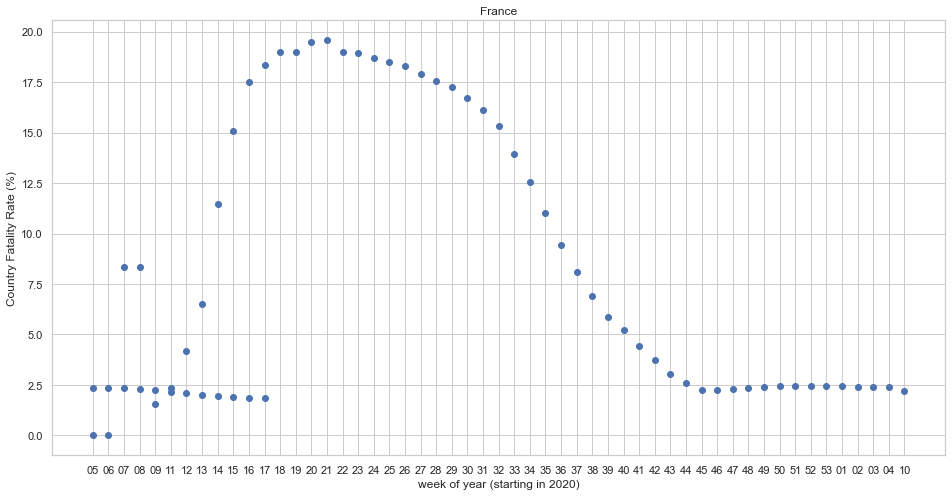

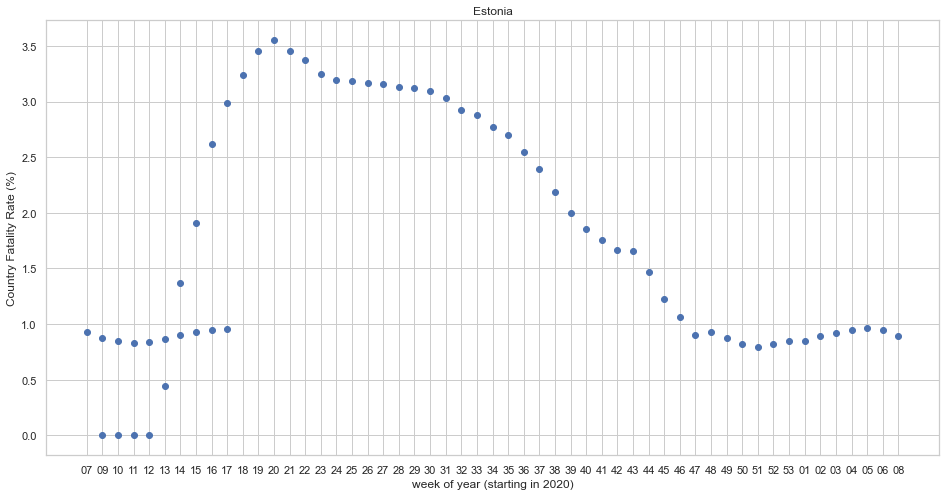

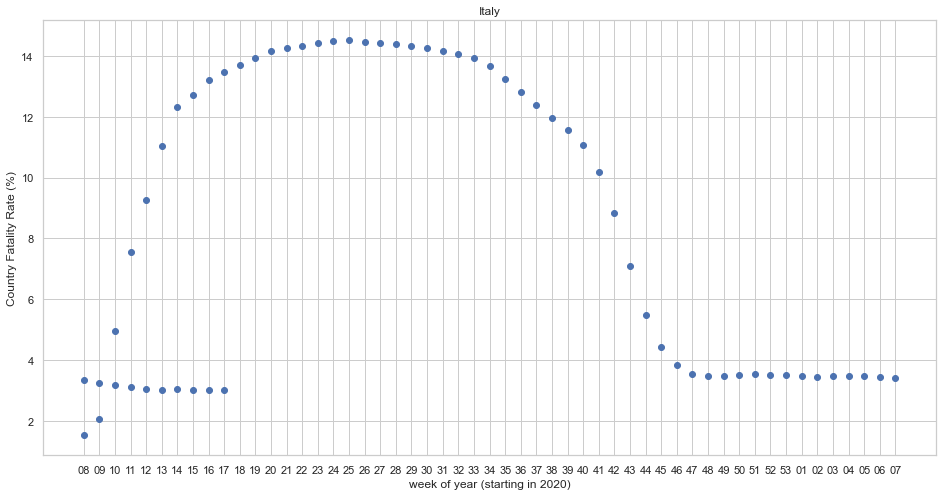

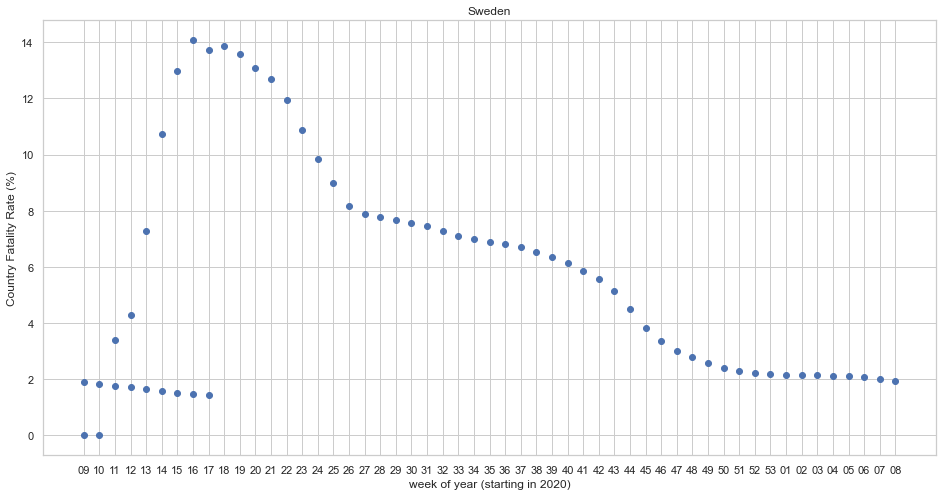

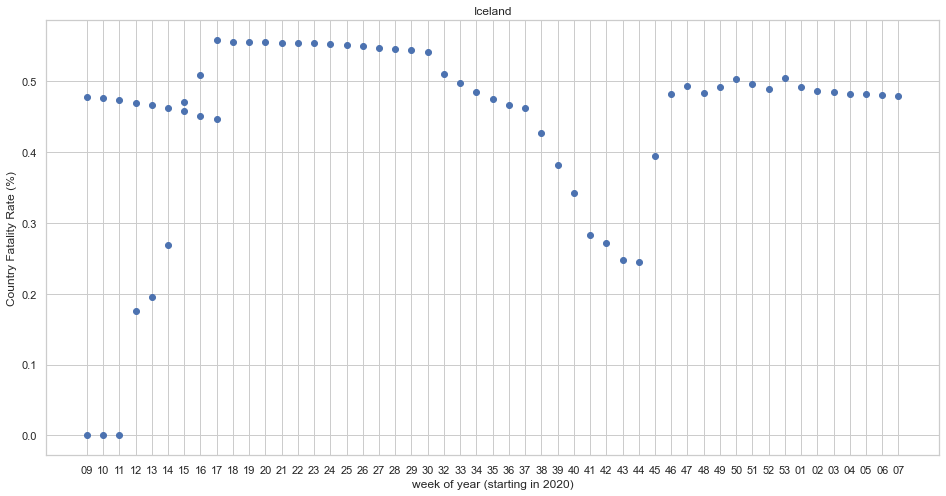

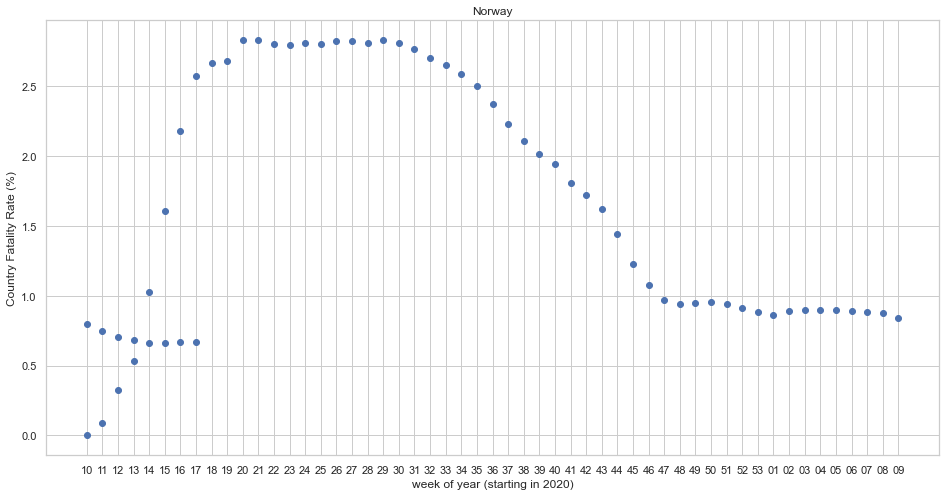

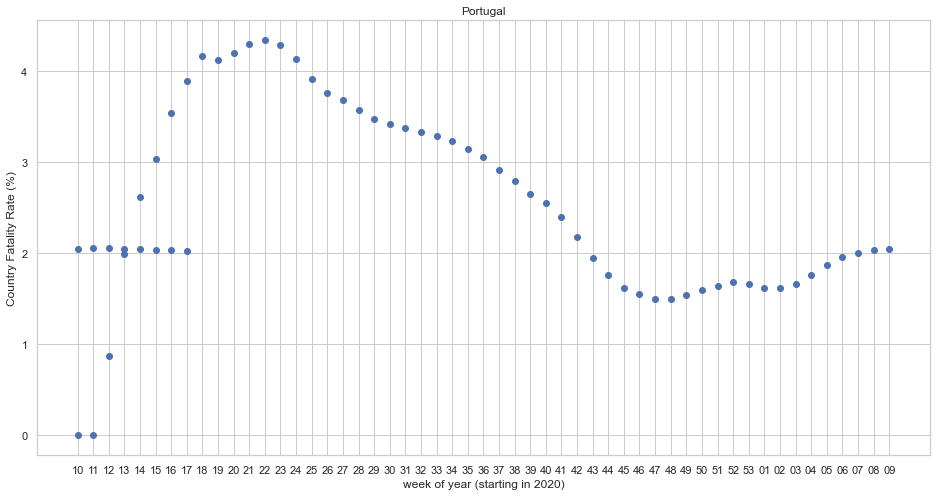

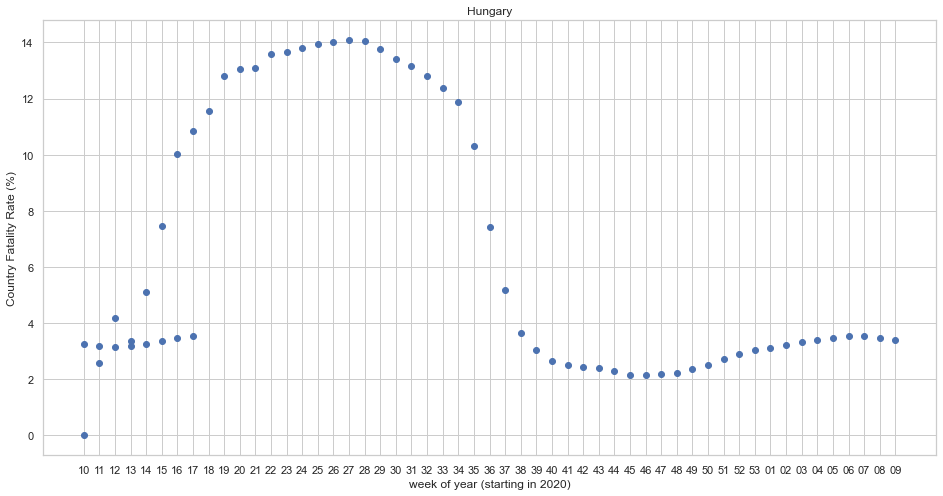

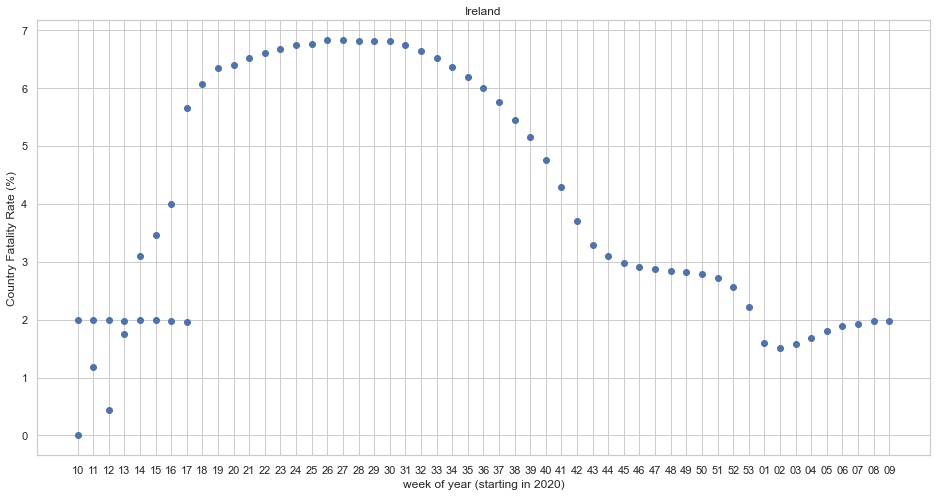

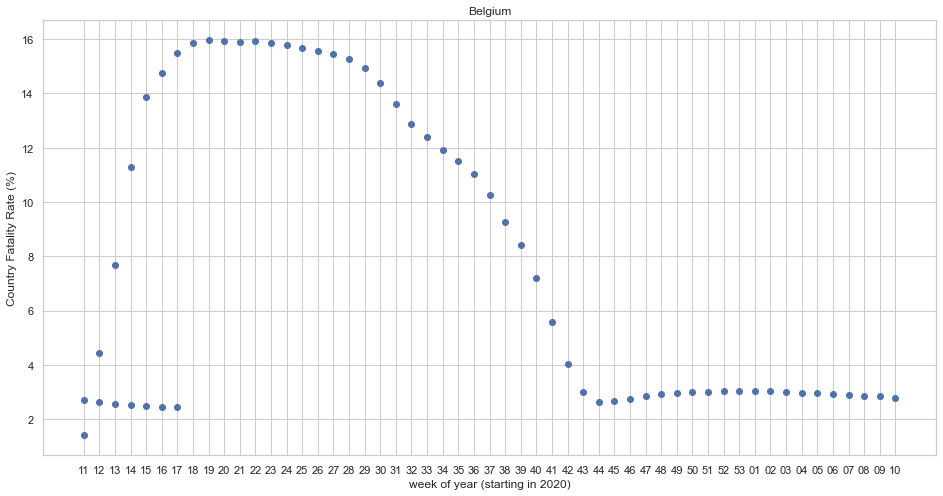

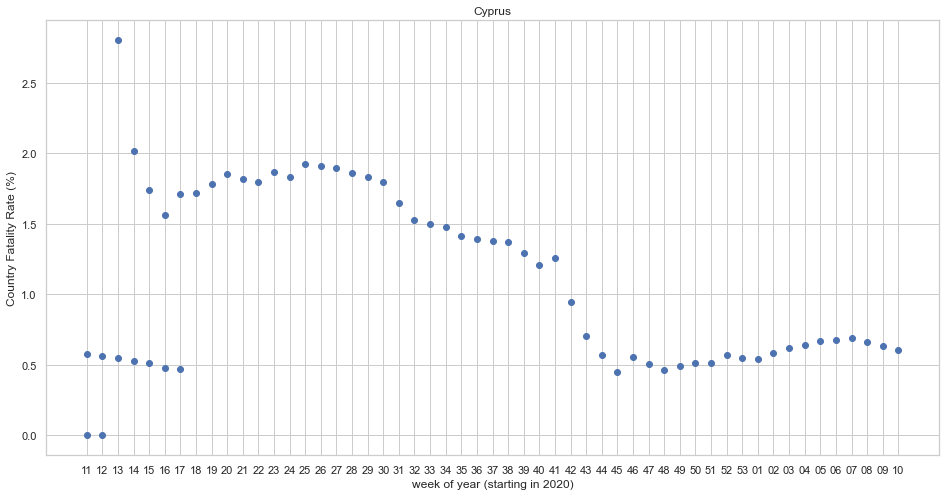

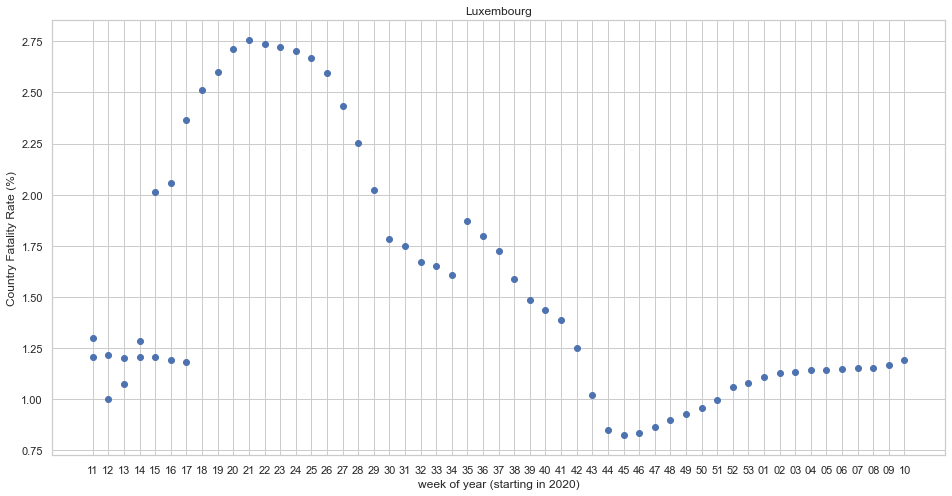

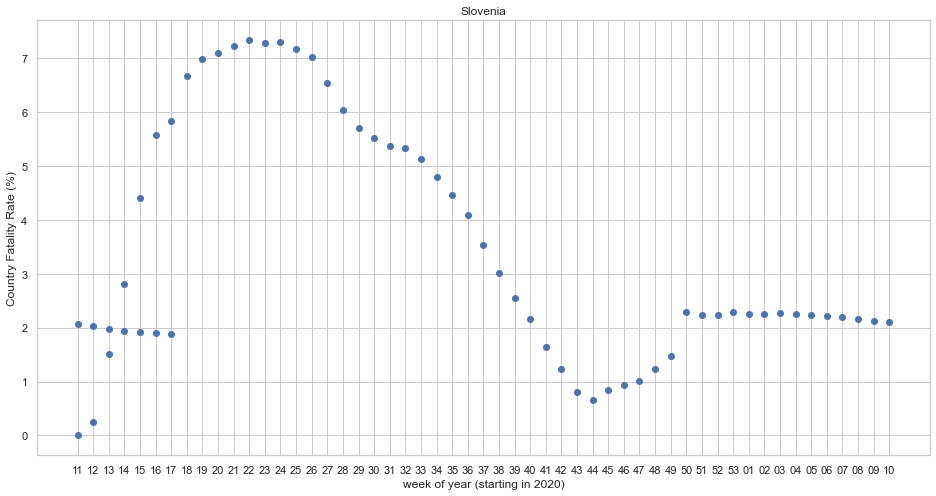

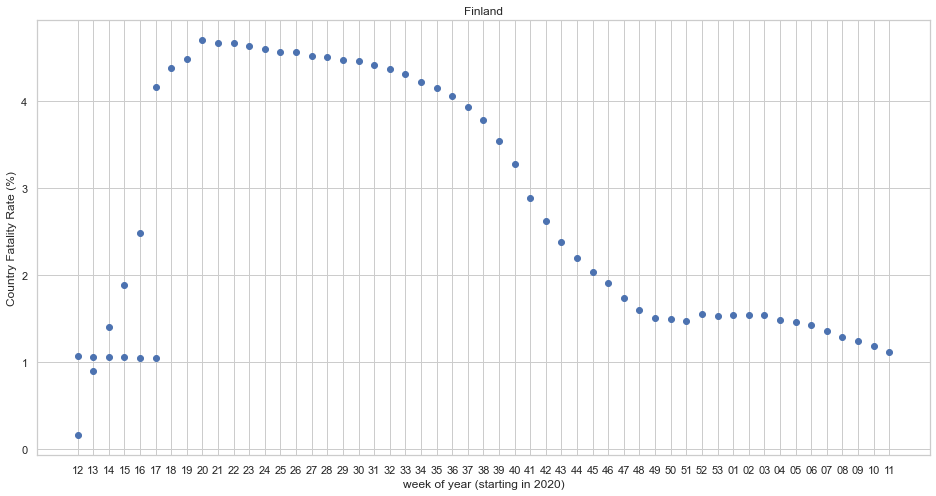

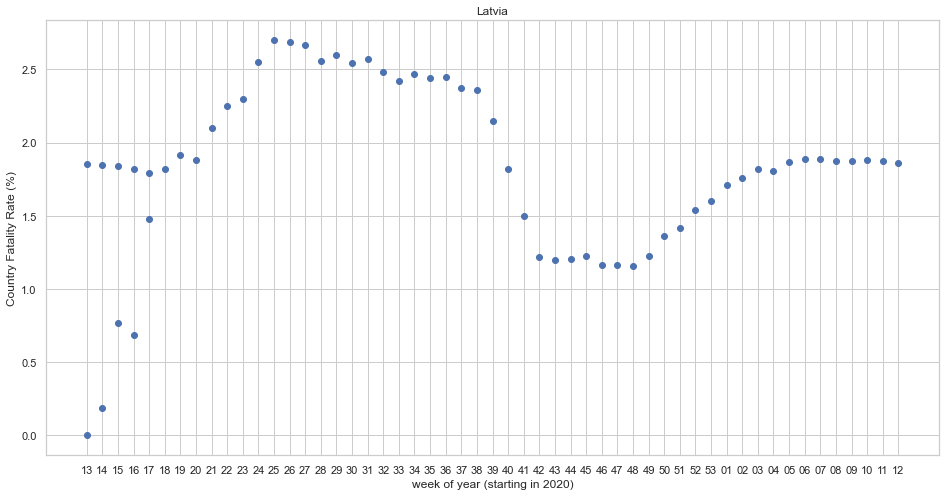

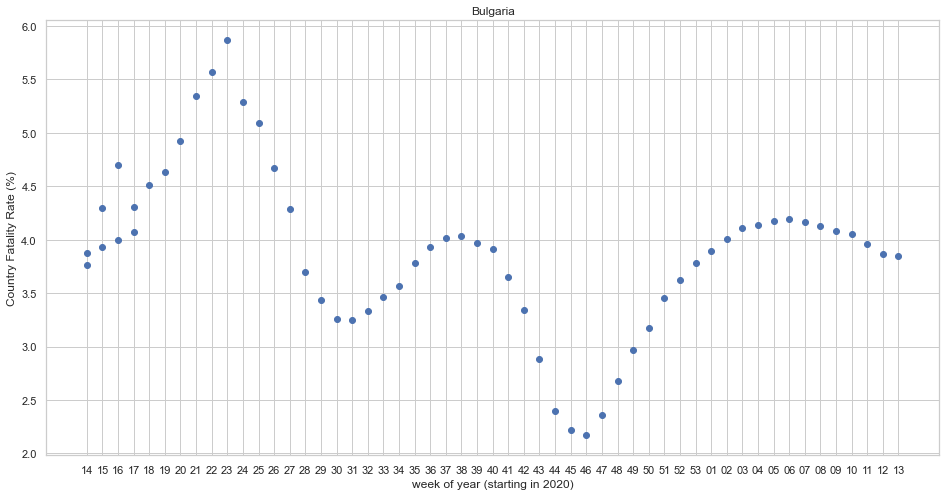

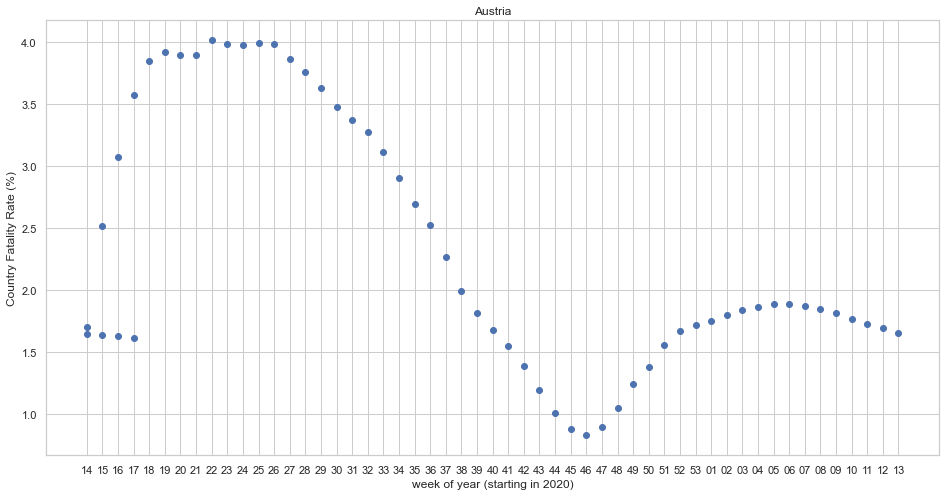

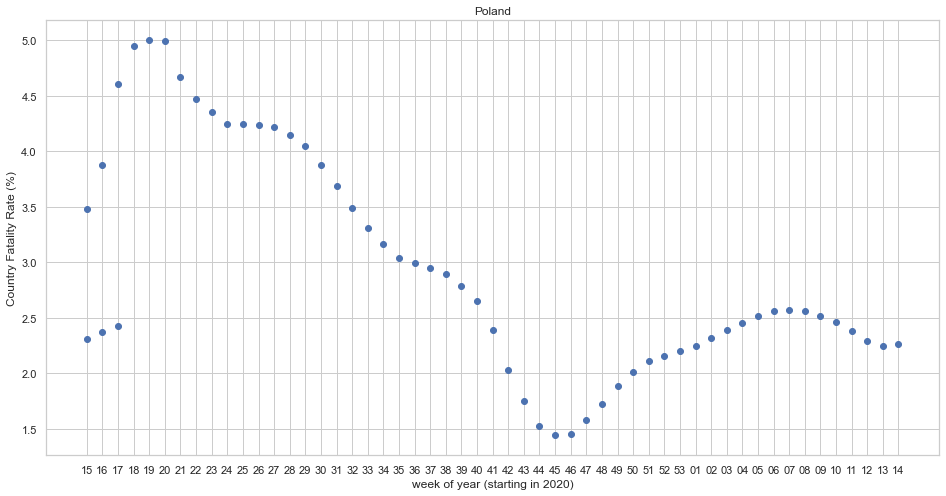

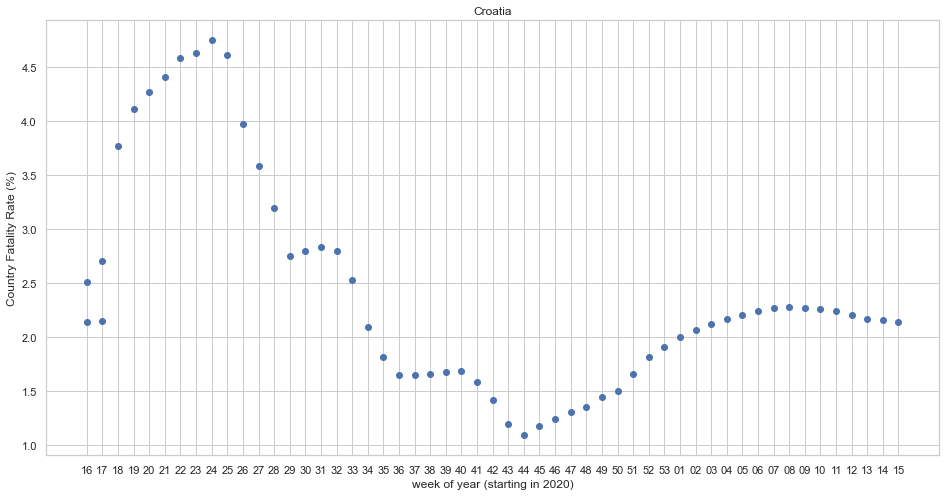

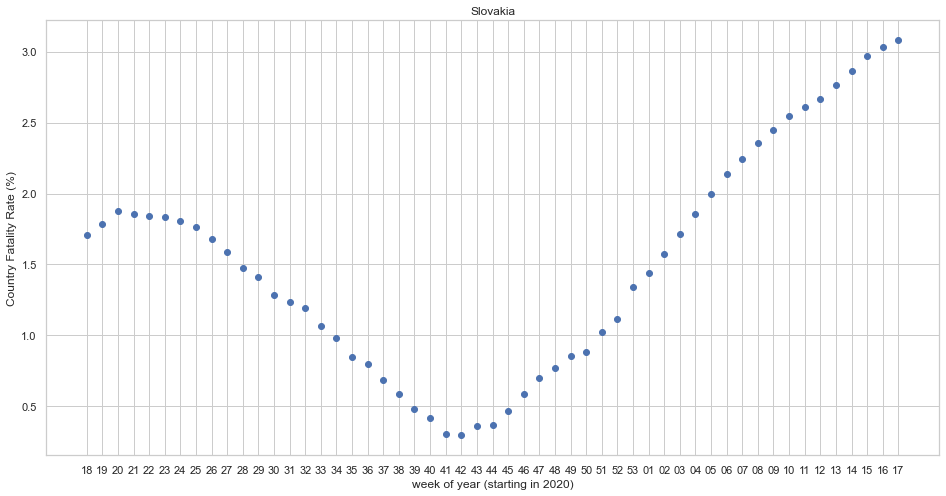

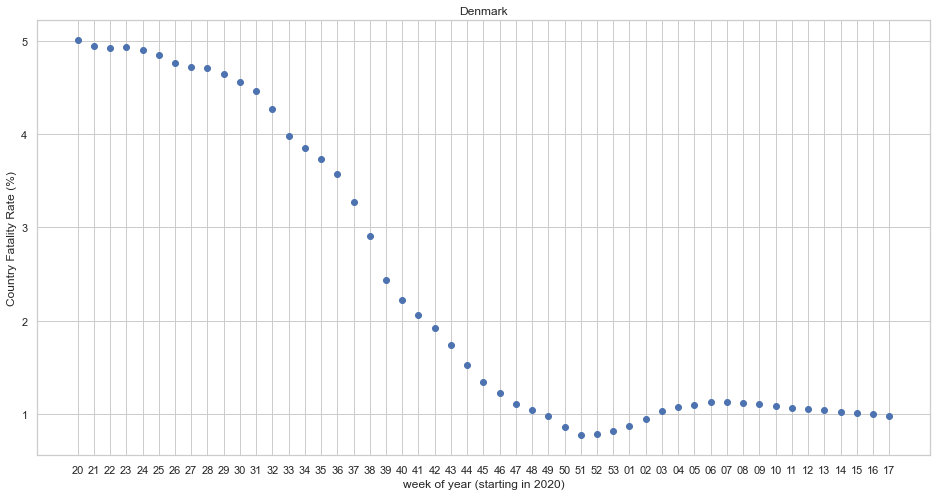

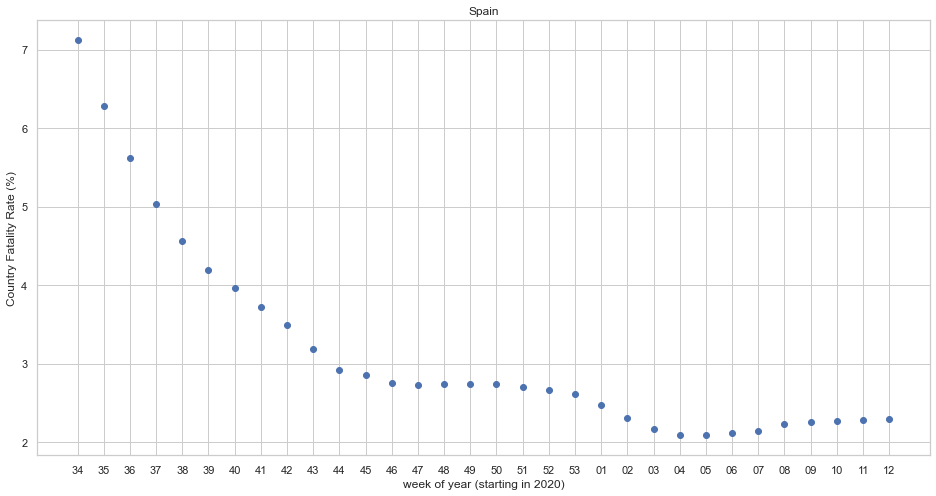

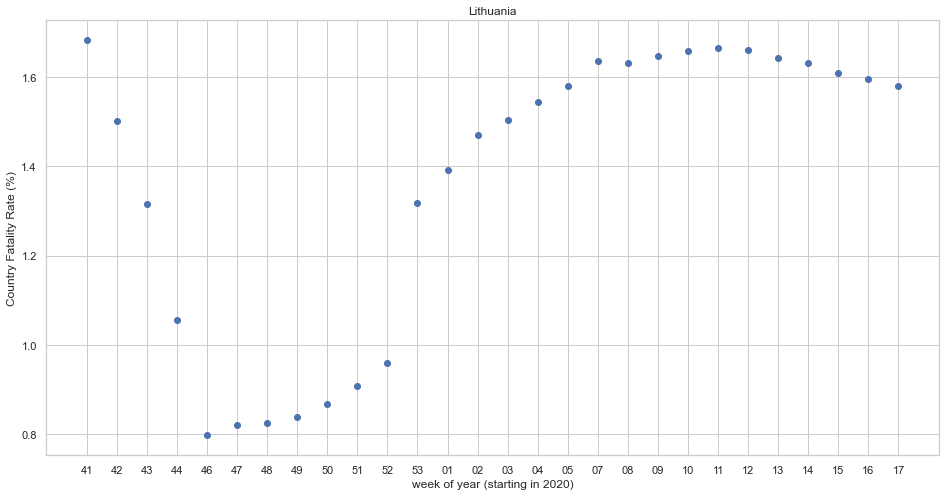

In [5]:
week_format_change=bigTable
week_format_change["year_week"]=week_format_change["year_week"].replace(r'2020-', '', regex=True)
week_format_change["year_week"]=week_format_change["year_week"].replace(r'2021-', '', regex=True)

unqCountries=bigTable["Country"].unique()
individualCountries=[]
for i in unqCountries:
    individualCountries.append(week_format_change[week_format_change["Country"]==i])
x_list=[]
y_list=[]

for i in individualCountries:
    #print(i["wkly ICU occupancy %"])
    x_list.append(i["year_week"])
    y_list.append(i["Country Fatality Rate"])
    #print(i["year_week"]) #["Median Age"]) #["wkly ICU occupancy %"])
    #y=(i["14dDR"])
for t in range(len(x_list)):   
    plt.figure(figsize=(16, 8))
    plt.scatter(x_list[t],y_list[t])
    plt.title(unqCountries[t])
    plt.xlabel("week of year (starting in 2020)")
    plt.ylabel("Country Fatality Rate (%)")
    plt.show()

Country  Hosp beds per 100k  Median Age  ICU&IMCU capacity per 100K  \
0       France               797.0        41.4                        11.6   
1       France               797.0        41.4                        11.6   
2       France               797.0        41.4                        11.6   
3      Estonia               704.0        42.7                        14.6   
4        Italy               471.0        45.5                        12.5   
...        ...                 ...         ...                         ...   
1298  Slovenia               540.0        44.5                         6.4   
1299   Belgium               672.0        41.4                        15.9   
1300   Croatia               615.0        43.0                        14.7   
1301   Hungary               816.0        42.3                        13.8   
1302    Sweden               358.0        41.2                         5.8   

      population year_week  cum_cases       14dCR  cum_deaths       14dDR  \
0       67320216        05          6    0.008913           0         0.0   
1       67320216        06         11    0.011884           0         0.0   
2       67320216        07         12    0.008913           1    0.014854   
3        1328976        07          0         0.0           0         0.0   
4       59641488        08        132    0.216292           2    0.033534   
...          ...       ...        ...         ...         ...         ...   
1298     2095861        17     241883  456.614251        4569   51.530135   
1299    11522440        17     997577  390.811321       24320   46.691499   
1300     4058165        17     335522  673.259959        7218  152.039161   
1301     9769526        17     784111   316.52508       27908  258.661474   
1302    10327589        17     985496  691.594137       14090   11.135222   

      wkly cases per 100k  wkly deaths per 100K  \
0                0.004456              0.000000   
1                0.007427              0.000000   
2                0.001485              0.001485   
3                0.000000              0.000000   
4                0.216292              0.003353   
...                   ...                   ...   
1298           222.533842              2.290228   
1299           179.206835              2.230430   
1300           307.676006              7.712846   
1301           129.555927             11.331154   
1302           342.471026              0.280801   

      7 day rolling avg hosp oc per 100K  7 day rolling avg ICU oc per 100K  \
0                               0.002546                           0.000424   
1                               0.013157                           0.001273   
2                               0.007852                           0.000424   
3                               0.010749                                NaN   
4                               0.030420                           0.006228   
...                                  ...                                ...   
1298                           25.581031                           6.366289   
1299                           20.321837                           6.378857   
1300                           47.347226                                NaN   
1301                           49.688037                                NaN   
1302                           16.298922                           3.240972   

      Country Fatality Rate  Country FR per week  Cum deaths per 100K  \
0                  0.000000             0.000000             0.000000   
1                  0.000000             0.000000             0.000000   
2                  8.333333           100.000000             0.001485   
3                       NaN                  NaN             0.000000   
4                  1.515152             1.550388             0.003353   
...                     ...                  ...                  ...   
1298               1.888930             1.029160           218.001098   

As can be seen, generally in each graph there is quite a lot of variance before converging on the final fatality rate per country shown in the above bar chart.

Lets visualize each countries deaths per 100k vs time 

### Visualization of weekly deaths per 100k vs week for each country

In [ ]:

week_format_change=bigTable
week_format_change["year_week"]=bigTable["year_week"].replace(r'2020-', '', regex=True)
week_format_change["year_week"]=bigTable["year_week"].replace(r'2021-', '', regex=True)

unqCountries=bigTable["Country"].unique()
individualCountries=[]
for i in unqCountries:
    individualCountries.append(week_format_change[week_format_change["Country"]==i])
x_list=[]
y_list=[]

for i in individualCountries:
    #print(i["wkly ICU occupancy %"])
    x_list.append(i["year_week"])
    y_list.append(i["wkly deaths per 100K"])
    #print(i["year_week"]) #["Median Age"]) #["wkly ICU occupancy %"])
    #y=(i["14dDR"])
for t in range(len(x_list)):   
    plt.figure(figsize=(16, 8))
    plt.scatter(x_list[t],y_list[t])
    plt.title(unqCountries[t])
    plt.xlabel("week of year (starting in 2020)")
    plt.ylabel("weekly covid deaths per 100k")
    plt.show()

### Visualise weekly cases per 100k vs weekly deaths per 100k for each country

In [ ]:
x_list_cases=[]
y_list_deaths=[]
for i in unqCountries:
    individualCountries.append(week_format_change[week_format_change["Country"]==i])

for i in individualCountries:
    #print(i["wkly ICU occupancy %"])
    x_list_cases.append(i["wkly cases per 100k"])
    y_list_deaths.append(i["wkly deaths per 100K"])
    #print(i["year_week"]) #["Median Age"]) #["wkly ICU occupancy %"])
    #y=(i["14dDR"])
for t in range(len(x_list_cases)):   
    plt.figure(figsize=(16, 8))
    plt.scatter(x_list_cases[t],y_list_deaths[t])
    plt.title(unqCountries[t])
    plt.xlabel("weekly covid cases per 100k")
    plt.ylabel("weekly covid deaths per 100k")
    plt.show()

As can be seen, there appears to be a clear correlation between weekly cases and weekly deaths as expected. The purpose of this study will mainly focus on pre-determined factors and how they effect the overall case fatality risk.

The data here appears quite random, but it is clear that as weekly covid cases per 100k increases, so too does weekly covid deaths

### Visualize countries median age vs cumulative fatality rate

In [ ]:
from numpy.polynomial.polynomial import polyfit
unqCountries=bigTable["Country"].unique()
last_Age_vals=[]
last_CFR_vals=[]

for j in unqCountries:
    last_Age_vals.append((bigTable[bigTable["Country"]==j].tail(1)["Median Age"]))
    last_CFR_vals.append((bigTable[bigTable["Country"]==j].tail(1)["Country Fatality Rate"]))
plt.figure(figsize=(16, 8))
plt.scatter(last_Age_vals,last_CFR_vals)
plt.title("age vs FR")
plt.xlabel("Median Age (years) by country")
plt.ylabel("Overall Fatality rate (deaths per cases %) by country")
for i, label in enumerate(unqCountries):
    #print(i)
    #print(label)
    plt.annotate(label, (last_Age_vals[i], last_CFR_vals[i]))

plt.show()

This is an interesting plot, with a moderately strong positive correlation indicating that an increase in the median age per country severly increasing the overall case fatality rate. Sadly, we see that Ireland appears to have a high fatality rate considering it's young median age.

### Visualize death's per capital vs median age of country's population

In [ ]:
unqCountries=bigTable["Country"].unique()
last_medAge_vals=[]
cum_deaths_vals=[]

for j in unqCountries:
    last_medAge_vals.append((bigTable[bigTable["Country"]==j].tail(1)["Median Age"]))
    cum_deaths_vals.append((bigTable[bigTable["Country"]==j].tail(1)["Cum deaths per 100K"]))
plt.figure(figsize=(16, 8))
plt.scatter(last_ICU_density_vals,cum_deaths_vals)
plt.title("Cumulative deaths per 100k vs Median age of country's population")
plt.xlabel("Median age of country's population")
plt.ylabel("Cumulative deaths per 100k")
for i, label in enumerate(unqCountries):
    #print(i)
    #print(label)
    plt.annotate(label, (last_medAge_vals[i], cum_deaths_vals[i]))
plt.show()    

# ICU bed density per country vs case fatality rate

In [ ]:
unqCountries=bigTable["Country"].unique()
last_ICU_density_vals=[]
last_CFR_vals=[]

for j in unqCountries:
    last_ICU_density_vals.append((bigTable[bigTable["Country"]==j].tail(1)["ICU&IMCU capacity per 100K"]))
    last_CFR_vals.append((bigTable[bigTable["Country"]==j].tail(1)["Country Fatality Rate"]))
plt.figure(figsize=(16, 8))
plt.scatter(last_ICU_density_vals,last_CFR_vals)
plt.title("ICU bed density vs CFR")
plt.xlabel("ICU bed density by country (beds per 100k)")
plt.ylabel("Overall Case Fatality rate (deaths per cases %) by country")
for i, label in enumerate(unqCountries):
    #print(i)
    #print(label)
    plt.annotate(label, (last_ICU_density_vals[i], last_CFR_vals[i]))
plt.show()    

There appears to be less correlation here than expected, and more randomness to the data, although it is evident that certain countries have a high fatality rate compared to both their icu bed density and their median age e.g. Hungary, Bulgaria

# Hospital bed density vs fatality rate

In [ ]:
unqCountries=bigTable["Country"].unique()
last_hos_density_vals=[]
last_CFR_vals=[]

for j in unqCountries:
    last_hos_density_vals.append((bigTable[bigTable["Country"]==j].tail(1)["Hosp beds per 100k"]))
    last_CFR_vals.append((bigTable[bigTable["Country"]==j].tail(1)["Country Fatality Rate"]))
plt.figure(figsize=(16, 8))
plt.scatter(last_hos_density_vals,last_CFR_vals)
plt.title("Hospital bed density vs CFR")
plt.xlabel("Hospital bed density by country (beds per 100k)")
plt.ylabel("Overall Case Fatality rate (deaths per cases %) by country")
for i, label in enumerate(unqCountries):
    #print(i)
    #print(label)
    plt.annotate(label, (last_hos_density_vals[i], last_CFR_vals[i]))

plt.show()    

There appears to be a stronger correlation between hospital bed density and CFR than between ICU density and CFR. Once again Bulgaria performs poorly in the context. Surprisingly, it seems that the more hospital beds available per country, the higher the fatality rate.

### Weekly country fatality rate

In [ ]:
week_format_change=bigTable
week_format_change["year_week"]=bigTable["year_week"].replace(r'2020-', '', regex=True)
week_format_change["year_week"]=bigTable["year_week"].replace(r'2021-', '', regex=True)

unqCountries=bigTable["Country"].unique()
individualCountries=[]
for i in unqCountries:
    individualCountries.append(week_format_change[week_format_change["Country"]==i])
x_list=[]
y_list=[]

for i in individualCountries:
    #print(i["wkly ICU occupancy %"])
    x_list.append(i["year_week"])
    y_list.append(i["Country FR per week"])
    #print(i["year_week"]) #["Median Age"]) #["wkly ICU occupancy %"])
    #y=(i["14dDR"])
for t in range(len(x_list)):   
    plt.figure(figsize=(16, 8))
    plt.scatter(x_list[t],y_list[t])
    plt.title(unqCountries[t])
    plt.xlabel("week of year (starting in 2020)")
    plt.ylabel("weekly country Fatality Rate (%)")
    plt.show()

### Visualization of weekly deaths per 100k vs hospital ICU occupancy %

In [ ]:
plt.figure(figsize=(16, 8))
plt.scatter(bigTable["wkly hos oc %"],bigTable["wkly deaths per 100K"])
plt.title("wkly deaths per 100k vs wkly hosp oc %")
plt.xlabel("wkly hos oc %")
plt.ylabel("wkly deaths per 100k")
plt.show()

As expected, there is a high correlation between increasing hospital occupancy and weekly deaths per 100k. It goes without saying that if hospital occupancy could stay low, covid deaths are likely to decrease.

### Visualization of Case Fatality Rate vs weekly covid cases

In [ ]:
week_format_change=bigTable
week_format_change["year_week"]=bigTable["year_week"].replace(r'2020-', '', regex=True)
week_format_change["year_week"]=bigTable["year_week"].replace(r'2021-', '', regex=True)

unqCountries=bigTable["Country"].unique()
individualCountries=[]
for i in unqCountries:
    individualCountries.append(week_format_change[week_format_change["Country"]==i])
x_list=[]
y_list=[]

for i in individualCountries:
    #print(i["wkly ICU occupancy %"])
    x_list.append(i["wkly cases per 100k"])
    y_list.append(i["Country FR per week"])
    #print(i["year_week"]) #["Median Age"]) #["wkly ICU occupancy %"])
    #y=(i["14dDR"])
for t in range(len(x_list)):   
    plt.figure(figsize=(16, 8))
    plt.scatter(x_list[t],y_list[t])
    plt.title(unqCountries[t])
    plt.xlabel("weekly cases per 100k")
    plt.ylabel("weekly country Fatality Rate (%)")
    plt.show()

Surprisingly, there was not a strong positive correlation between cases and the CFR of a country as was expected.

### Visualization of weekly covid deaths per 100k population vs 7 day rolling avg hospital occupancy %

In [ ]:
plt.figure(figsize=(16, 8))
plt.scatter(bigTable["7 day avg hos oc %"],bigTable["wkly deaths per 100K"])
plt.title("wkly deaths per 100k vs 7 day avg hospital occupancy %")
plt.xlabel("7 day avg hospital occupancy oc %")
plt.ylabel("wkly deaths per 100k")
plt.show()

Once again, we can see that there is a strong correlation between weekly ICU occupancy and weekly deaths per 100K as expected. 

# Modelling

We shall construct a linear model to investigate how a country's predetermined factors (hospital and ICU bed density and it's populations median age) impact on it's case fatality rate.

We shall also investigate how variable factors such as the ICU and hospital occupancy % of it's capacity impact on it's case fatality rate, however it is only country's pre-determined factors which shall be used for further investigation.

This test will be performed at the 95% confidence level, hence any variables with a P value greater thatn 0.05 should be considered insignificant.

First, the data set must be broken down and seperated into a train and testing data set.

### Build train and test data set

In [28]:
#df =bigTable  #pd.DataFrame(np.random.randn(100, 2))
bigTable=bigTable.dropna()
#(i.dropna())
msk = np.random.rand(len(bigTable)) < 0.8
train_data = bigTable[msk]
test_data = bigTable[~msk]
train_data=train_data.dropna()
test_data=test_data.dropna()
#len(train)
#len(test)
#test_data
#bigTable
#train_data
#test_data

### Factors which effect the case fatality rate of a country

This report shall examine how the characteristics of a country can effect the case fatality rate of a country. In particular, we shall investigate the fixed factors of each country which are not dependant on case numbers such as the median age of the population, the number of hospital beds per 100k population and the number of icu beds per 100k population.

In [46]:
#n=60
t1=bigTable
#t1.drop(t1.tail(n).index,
#        inplace = True)

In [47]:
t1

Country  Hosp beds per 100k  Median Age  ICU&IMCU capacity per 100K  \
0       France               797.0        41.4                        11.6   
1       France               797.0        41.4                        11.6   
2       France               797.0        41.4                        11.6   
3      Estonia               704.0        42.7                        14.6   
4        Italy               471.0        45.5                        12.5   
...        ...                 ...         ...                         ...   
1298  Slovenia               540.0        44.5                         6.4   
1299   Belgium               672.0        41.4                        15.9   
1300   Croatia               615.0        43.0                        14.7   
1301   Hungary               816.0        42.3                        13.8   
1302    Sweden               358.0        41.2                         5.8   

      population year_week  cum_cases       14dCR  cum_deaths       14dDR  \
0       67320216   2020-05          6    0.008913           0         0.0   
1       67320216   2020-06         11    0.011884           0         0.0   
2       67320216   2020-07         12    0.008913           1    0.014854   
3        1328976   2020-07          0         0.0           0         0.0   
4       59641488   2020-08        132    0.216292           2    0.033534   
...          ...       ...        ...         ...         ...         ...   
1298     2095861   2021-17     241883  456.614251        4569   51.530135   
1299    11522440   2021-17     997577  390.811321       24320   46.691499   
1300     4058165   2021-17     335522  673.259959        7218  152.039161   
1301     9769526   2021-17     784111   316.52508       27908  258.661474   
1302    10327589   2021-17     985496  691.594137       14090   11.135222   

      wkly cases per 100k  wkly deaths per 100K  \
0                0.004456              0.000000   
1                0.007427              0.000000   
2                0.001485              0.001485   
3                0.000000              0.000000   
4                0.216292              0.003353   
...                   ...                   ...   
1298           222.533842              2.290228   
1299           179.206835              2.230430   
1300           307.676006              7.712846   
1301           129.555927             11.331154   
1302           342.471026              0.280801   

      7 day rolling avg hosp oc per 100K  7 day rolling avg ICU oc per 100K  \
0                               0.002546                           0.000424   
1                               0.013157                           0.001273   
2                               0.007852                           0.000424   
3                               0.010749                                NaN   
4                               0.030420                           0.006228   
...                                  ...                                ...   
1298                           25.581031                           6.366289   
1299                           20.321837                           6.378857   
1300                           47.347226                                NaN   
1301                           49.688037                                NaN   
1302                           16.298922                           3.240972   

      Country Fatality Rate  Country FR per week  Cum deaths per 100K  \
0                  0.000000             0.000000             0.000000   
1                  0.000000             0.000000             0.000000   
2                  8.333333           100.000000             0.001485   
3                       NaN                  NaN             0.000000   
4                  1.515152             1.550388             0.003353   
...                     ...                  ...                  ...   
1298               1.888930             1.029160           218.001098   

In [42]:
#it's important to take only the final value of a country's fatality rate
tempdf=t1.sort_values('year_week').groupby('Country').tail(1)
y_train6 = tempdf['Country Fatality Rate']

X_train6 = tempdf[['Median Age','ICU&IMCU capacity per 100K','Hosp beds per 100k']] # 'ICU&IMCU capacity per 100K','wkly cases per 100k','Median Age']]
X_train6 = sm.add_constant(X_train6)
mod6 = sm.OLS(y_train6, X_train6).fit()
mod6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Country Fatality Rate   R-squared:                       0.241
Model:                               OLS   Adj. R-squared:                  0.121
Method:                    Least Squares   F-statistic:                     2.014
Date:                   Sun, 09 May 2021   Prob (F-statistic):              0.146
Time:                           20:27:41   Log-Likelihood:                -26.496
No. Observations:                     23   AIC:                             60.99
Df Residuals:                         19   BIC:                             65.53
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.7927      3.073     -1.560      0.135     -11.225       1.639
Median Age                     0.1468      0.077      1.915      0.071      -0.014       0.307
ICU&IMCU capacity per 100K    -0.0168      0.038     -0.436      0.668      -0.097       0.064
Hosp beds per 100k             0.0012      0.001      1.007      0.326      -0.001       0.004
==============================================================================
Omnibus:                        1.080   Durbin-Watson:                   2.766
Prob(Omnibus):                  0.583   Jarque-Bera (JB):                1.010
Skew:                           0.362   Prob(JB):                        0.603
Kurtosis:                       2.272   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Surprisingly, both the hospital and icu bed density variables had P values greater than 0.05 and hence were considered insignificant when running a linear model to predict the covid fatality rate of a country. The model was attempted again, this time removing the insignificant variables and only keeping the median age.


In [43]:
tempdf_train=t1.sort_values('year_week').groupby('Country').tail(1)
#tempdf_train=tempdf_train.drop(["population","year_week","cum_cases","14dCR","cum_deaths","wkly hosp oc per 100K","wkly ICU oc per 100K","Country FR per week","wkly ICU occupancy %","wkly hos oc %","14dDR","wkly cases per 100k","wkly deaths per 100K"],axis=1)
y_train7 = tempdf_train['Country Fatality Rate']

tempdf_test=t1.sort_values('year_week').groupby('Country').tail(1)
#tempdf_test=tempdf_test.drop(["population","year_week","cum_cases","14dCR","cum_deaths","wkly hosp oc per 100K","wkly ICU oc per 100K","Country FR per week","wkly ICU occupancy %","wkly hos oc %","14dDR","wkly cases per 100k","wkly deaths per 100K"],axis=1)
y_test7 = tempdf_test['Country Fatality Rate']

X_train7=tempdf_train[['Median Age']]
X_train7 = sm.add_constant(X_train7)
X_test7 = tempdf_test[['Median Age']] #'ICU&IMCU capacity per 100K','Hosp beds per 100k']] # 'ICU&IMCU capacity per 100K','wkly cases per 100k','Median Age']]
X_test7 = sm.add_constant(X_test7)
mod7 = sm.OLS(y_train7, X_train7).fit()
mod7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Country Fatality Rate   R-squared:                       0.201
Model:                               OLS   Adj. R-squared:                  0.163
Method:                    Least Squares   F-statistic:                     5.273
Date:                   Sun, 09 May 2021   Prob (F-statistic):             0.0321
Time:                           20:28:03   Log-Likelihood:                -27.095
No. Observations:                     23   AIC:                             58.19
Df Residuals:                         21   BIC:                             60.46
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.0016      2.993     -1.671      0.110     -11.226       1.223
Median Age     0.1652      0.072      2.296      0.032       0.016       0.315
==============================================================================
Omnibus:                        2.084   Durbin-Watson:                   2.777
Prob(Omnibus):                  0.353   Jarque-Bera (JB):                1.760
Skew:                           0.633   Prob(JB):                        0.415
Kurtosis:                       2.514   Cond. No.                         727.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It can be seen that the correlation coefficient only decreased slightly after taking out the insignificant values (0.280 vs 0.257), hence we should proceed with our model of median age vs case fatality rate

As the aim of this study was to analyse how pre-determined factors impact on a country's case fatality rate, this model "mod7" of country fatality rate vs median age will be used.

For illustration purposes, other models depicting how undetermined factors such as the occupancy % of hospital and ICU beds impact on death and fatality rates.

### Model of weekly deaths per 100K vs weekly ICU and hospital occupancy %

In [ ]:
bigTable.head()

In [ ]:
y_train = train_data['wkly deaths per 100K']
y_test = test_data['wkly deaths per 100K']
X_test = test_data[['7 day avg ICU occupancy %', '7 day avg hos oc %']] #,'wkly cases per 100k']]
X_test = sm.add_constant(X_test)

X_train = train_data[['7 day avg ICU occupancy %', '7 day avg hos oc %']] #,'wkly cases per 100k']]
X_train = sm.add_constant(X_train)

mod1 = sm.OLS(y_train, X_train).fit()
mod1.summary()
#y_pred=mod1.predict(y_test,X_test)

As expected, hospital and ICU occupancy % is strongly correlated with the weekly deaths per capita of a country.

### Model of median age, weekly cases hos and icu density impact on weekly deaths per 100k

In [ ]:
y_train2 = train_data['wkly deaths per 100K']
y_test2 = test_data['wkly deaths per 100K']
X_test2 = test_data[['Median Age','ICU&IMCU capacity per 100K','Hosp beds per 100k','wkly cases per 100k']]
X_test2 = sm.add_constant(X_test2)

X_train2 = train_data[['Median Age','ICU&IMCU capacity per 100K','Hosp beds per 100k','wkly cases per 100k']] # 'ICU&IMCU capacity per 100K','wkly cases per 100k','Median Age']]
X_train2 = sm.add_constant(X_train2)
#,'Hosp beds per 100k'
#'ICU&IMCU capacity per 100K'
mod2 = sm.OLS(y_train2, X_train2).fit()
mod2.summary()
#y_pred=mod1.predict(y_test,X_test)

As was demonstrated earlier, hospital and ICU bed capacity have an insignificant impact on the fatalities a country experiences from covid-19. It is demonstrated here that as expected the weekly case rates have an impact on the death rates. This suggests that even with a high capacity of ICU and hospital beds, there is little a country can do to prevent covid fatalities once case rates rise.

### ICU occupancy vs ICU capacity and case numbers

In [ ]:
y_train3 = train_data['7 day avg ICU occupancy %']
y_test3 = test_data['7 day avg ICU occupancy %']
X_test3 = test_data[['ICU&IMCU capacity per 100K',"wkly cases per 100k"]] #,'wkly cases per 100k']]
X_test3 = sm.add_constant(X_test3)

X_train3 = train_data[['ICU&IMCU capacity per 100K','wkly cases per 100k']]
X_train3 = sm.add_constant(X_train3)

mod3 = sm.OLS(y_train3, X_train3).fit()
mod3.summary()
#y_pred=mod1.predict(y_test,X_test)

As expected, the ICU occupancy rates has a high correlation with covid cases and it's original capacity.

### Weekly fatality rate of a country vs weekly cases per country

In [ ]:
y_train8 = train_data['Country FR per week']
y_test8 = test_data['Country FR per week']
X_test8 = test_data["wkly cases per 100k"] #,'wkly cases per 100k']]
X_test8 = sm.add_constant(X_test8)

X_train8 = train_data['wkly cases per 100k']
X_train8 = sm.add_constant(X_train8)

mod8 = sm.OLS(y_train8, X_train8).fit()
mod8.summary()

Surprisingly, there was little correlation between the fatality rate of a country and it's weekly covid cases

# Checking assumptions of linear regression

As was mentioned previously, we shall only be pursuing our investigation of the effect pre determined factors have on a country's case fatality rate. Hence, we shall only be investigating if our model "mod7" of a country's fatality rate vs it's median age passes the assumptions to be considered a linear model.

# Linearity

taken from here
https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

We shall first check if there is a linear relationship between the dependant and independant variables. This assumes that there is a linear relationship between the predictors (e.g. independent variables or features) and the response variable (e.g. dependent variable or label)

In [ ]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
linear_assumption(mod7, X_train7, y_train7)

We can see a reasonable enough linear relationship between the predictor variables and the response, hence we can say that the assumption of linearity is passed by the training data. We shall now proceed to test it on the testing data.

In [ ]:
linear_assumption(mod7, X_test7, y_test7)

Once again, a reasonably linear response is observed, hence it can be assumed that the linearity assumption is passed by the testing data.

# Normality of error terms

We shall now check if the error terms of the model are normally distributed.

In [ ]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

In [ ]:
normal_errors_assumption(mod7, X_train7, y_train7)

As the training data passed the assumption, we shall now test on the test data.

In [ ]:
normal_errors_assumption(mod7, X_test7, y_test7)

# No multicollinearity amongst predictors

As there is only one predictor, there can be no multicollinearity amongst predictors

# No autocorrelation of error terms

In [ ]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [ ]:
autocorrelation_assumption(mod7, X_train7, y_train7)

# Homoscedasticity of error terms

In [ ]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

In [ ]:
homoscedasticity_assumption(mod6, X_train6, y_train6)

# Model performance evaluation

Now that we are satisfied that the model passes the assumptions necessary to be considered a Best Linear Unbiased Estimator (BLUE), we can test its performance. Via it's root mean square error. This is the sum total of the difference between the predicted values and the actual values when measured on the test data.

In [50]:
pred_train=mod7.predict(X_train7)
actual_train=train_data["Country Fatality Rate"]
MSE_train = np.square(np.subtract(actual_train,pred_train)).mean()
RMSE_train = math.sqrt(MSE_train)
RMSE_train

pred_test=mod7.predict(X_test7)
actual_test=test_data["Country Fatality Rate"]
MSE_test = np.square(np.subtract(actual_test,pred_test)).mean()
RMSE_test = math.sqrt(MSE_test)
#RMSE_test
#RMSE
RMSE_test

0.828908915415879

In [ ]:
RMSE_train

A value close to 0 (like the value found here) is preferably for a root mean squared error.

### Exploration of a country's performance in terms of it's expected case fatality rate

The scatter plot for the median age of a country's population versus it's mortality rate is shown below along with the line of best fit as predicted by our model. Countries on this line have a fatality rate in line what would be expected of their median age. Countries below the line have a fatality rate better (lower) than would be expected of their median age, and countries above the line have a worse fatality rate than should be expected of their median age.

C:\Users\Andrew\Anaconda3\envs\nltk_test\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


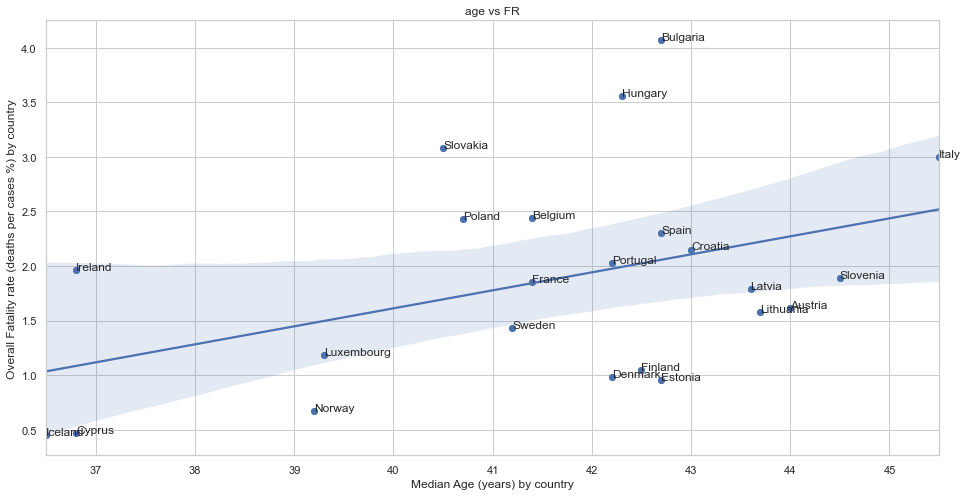

In [48]:

from numpy.polynomial.polynomial import polyfit
unqCountries=bigTable["Country"].unique()
last_Age_vals=[]
last_CFR_vals=[]

for j in unqCountries:
    last_Age_vals.append((bigTable[bigTable["Country"]==j].tail(1)["Median Age"]))
    last_CFR_vals.append((bigTable[bigTable["Country"]==j].tail(1)["Country Fatality Rate"]))
plt.figure(figsize=(16, 8))
plt.scatter(last_Age_vals,last_CFR_vals)
plt.title("age vs FR")
plt.xlabel("Median Age (years) by country")
plt.ylabel("Overall Fatality rate (deaths per cases %) by country")

import seaborn as sns
sns.regplot(last_Age_vals,last_CFR_vals)
for i, label in enumerate(unqCountries):
    #print(i)
    #print(label)
    plt.annotate(label, (last_Age_vals[i], last_CFR_vals[i]))

plt.show()

### Test accuracy on worldwide model

As the model only requires data for median age and a country's case fatality rate, we can test the accuracy of the model on a larger data set provided by combining our initial data set of "medianAge" and "worldWideCasesAndDeaths".

In [ ]:
medianAge.head()

In [ ]:
worldWideCasesAndDeaths.head()

a quick join of the tables is required, along with calculating the case fatality rate of each country

In [49]:
final_check= pd.merge(worldWideCasesAndDeaths,medianAge,  how='left', left_on=['Country'], right_on = ['Country'])
final_check=final_check.dropna()
FC=final_check.sort_values('year_week').groupby('Country').tail(1)
FC["Country CFR"]=FC["cum_deaths"]*100/FC["cum_cases"]
X_check = sm.add_constant(FC["Median Age"])
final_pred_train=mod7.predict(X_check)

final_actual=FC["Country CFR"]
MSE_final = np.square(np.subtract(final_actual,final_pred_train)).mean()
RMSE_final = math.sqrt(MSE_final)
RMSE_final
#y_2 =FC['Country CFR']
#y_test2 = test_data['wkly deaths per 100K']
#X_test2 = test_data[['Median Age','ICU&IMCU capacity per 100K','Hosp beds per 100k','wkly cases per 100k']]
#X_test2 = sm.add_constant(X_test2)

#X_2 = FC["Median Age"]# train_data[['Median Age','wkly cases per 100k']] # 'ICU&IMCU capacity per 100K','wkly cases per 100k','Median Age']]
#X_2 = sm.add_constant(X_2)
#,'Hosp beds per 100k'
#'ICU&IMCU capacity per 100K'
#mod_final = sm.OLS(y_2, X_2).fit()
#mod_final.summary()
#FC["Median Age"]

NameError: name 'worldWideCasesAndDeaths' is not defined

There is a larger root mean square error for the data analysed over the worldwide data set than the previous EU only data set. This is not unexpected, as countries in other continents can expect to have different experiences in terms of GDP per capita amongst other external factors.

# Conclusion

Data sets of differing forms such as xml, html and json files were successfully pulled and extracted from online sources, converted appropriately to dataframes and uploaded to an online database. These tables were pulled from the database, data manipulation and cleaning occurred so that the tables could be joined successfully before being re-uploaded to the database in it's preferred form.

Various visualizations depicting the data uploaded were constructed, before the task of building a linear model began.

The model of median age vs fatality rate passes the assumptions necessary to be considered a Best Linear Unbiased Estimator and provides reasonable predictions when validating on an external set of test data. After testing on a wider set of countries outside of the EU, less accurate results were provided hence the model was deemed fit for use only on countries within the EU.

# Pulling others datasets and joint analysis

In [ ]:
cleanedTable

In [8]:
bigTable_download=ds.MongoToDataFrameSpecificDataframe(ds.client,ds.database_name,"cleanedTable",True)
Temp_VaxData=ds.MongoToDataFrameSpecificDataframe(ds.client,"COVID","Cleaned",True)

Connecting to Mongo Database
Pulling dataframe from Mongo Database
Connecting to Mongo Database
Pulling dataframe from Mongo Database


In [9]:
#pd.DataFrame(TempDF[0])
#pd.DataFrame(TempDF)
#Temp_VaxData
bigTable=bigTable_download
vax_data=pd.DataFrame(Temp_VaxData['records'][0])

First we must convert the date format such that it is in the same form of "year_week" as that of our processed data.

In [10]:
vax_data["Date"]=pd.to_datetime(vax_data["Date"])
vax_data['year_week'] = vax_data['Date'].dt.strftime('%Y-%U')


First we shall seperate the targetgroup into 2 categories, one for over60s and one for under60s to classify higher and lower risk groups.
We will only focus on vaccines given to over 60s, as they have a higher chance of death from covid.

In [11]:
mydict2={'Age60_69':"over60s",'Age70_79':"over60s",'Age80+':"over60s","Age18_24":"under60s","Age25_49":"under60s","Age50_59":"under60s"}
vax_data=vax_data.replace({"TargetGroup": mydict2})
vax_data=vax_data[vax_data["TargetGroup"]=="over60s"]

We shall also drop the distinction between vaccines.

In [12]:
vax_data=vax_data.drop(columns = ['Vaccine',"NumberDosesReceived","FirstDoseRefused"])

We will now find the total number of first and second doses given out in a week, as well as the total numberdoses received a week.

In [13]:
#df.groupby(by=["b"]).sum()
agg_on=['FirstDose',"SecondDose"]
vax_data_cleaned=vax_data.groupby(['ReportingCountry','year_week',"Population","TargetGroup"])[agg_on].sum().reset_index()
vax_data_cleaned=vax_data_cleaned.sort_values(by=['year_week'])
#vax_data_cleaned

We will add the cumulative sum of the doses. We will now change the column of "ReportingCountry" to an actual country name to allow a join with our processed table and see the effect increase in vaccines has on hospitalizations and deaths.

We will add the cumulative sum of the doses. We will now change the column of "ReportingCountry" to an actual country name to allow a join with our processed table and see the effect increase in vaccines has on hospitalizations and deaths.

In [14]:
mydict_countries={'AT':"Austria",'BE':"Belgium",'BG':"Bulgaria","CY":"Cyprus","CZ":"Czech Republic","DK":"Denmark","EE":"Estonia",
        "EL":"Greece","ES":"Spain","FI":"Finland","FR":"France","HR":"Croatia","HU":"Hungary","IE":"Ireland","IS":"Iceland","IT":"Italy",
        "LT":"Lithuania","LU":"Luxembourg","LV":"Latvia","MT":"Malta","NO":"Norway","PL":"Poland","PT":"Portugal","SE":"Serbia",
        "SI":"Slovenia","SK":"Slovakia"}
vax_data_cleaned=vax_data_cleaned.replace({"ReportingCountry": mydict_countries})

We shall get the cumulative number of first and second doses per country.

In [15]:
vax_data_cleaned["cum1stDose"]=vax_data_cleaned.groupby('ReportingCountry')['FirstDose'].cumsum()
vax_data_cleaned["cum2ndDose"]=vax_data_cleaned.groupby('ReportingCountry')['SecondDose'].cumsum()


In [20]:
vax2=vax_data_cleaned.rename(columns={"ReportingCountry":"Country"})
hospital_and_vax= pd.merge(bigTable, vax2,  how='left', left_on=['year_week','Country'], right_on = ['year_week','Country'])
hospital_and_vax=hospital_and_vax.dropna()


Country  Hosp beds per 100k  Median Age  ICU&IMCU capacity per 100K  \
851   Luxembourg               639.0        39.3                        24.8   
853     Portugal               371.0        42.2                         4.2   
855     Slovenia               540.0        44.5                         6.4   
861      Finland               754.0        42.5                         6.1   
862       France               797.0        41.4                        11.6   
...          ...                 ...         ...                         ...   
1269     Ireland               613.0        36.8                         6.5   
1272     Estonia               704.0        42.7                        14.6   
1273  Luxembourg               639.0        39.3                        24.8   
1274     Denmark               429.0        42.2                         6.7   
1275       Italy               471.0        45.5                        12.5   

      population year_week  cum_cases        14dCR  cum_deaths       14dDR  \
851       626108   2020-51      44067  1019.472679         440  143.745169   
853     10295909   2020-51     374121   501.626423        6134  113.734494   
855      2095861   2020-51     105899   958.746787        2368  529.615275   
861      5525292   2020-51      33162   100.103307         489   13.392957   
862     67320216   2020-51    2473354   268.651842       60549    80.12452   
...          ...       ...        ...          ...         ...         ...   
1269     4964440   2021-16     246633   114.574856        4873   17.726068   
1272     1328976   2021-16     120378   446.584438        1143   79.760658   
1273      626108   2021-16      66202   407.597411         790   35.137708   
1274     5822763   2021-16     248326   172.083253        2477    5.839152   
1275    59641488   2021-16    3962674   323.365507      119238    83.56599   

      ...  Country FR per week  Cum deaths per 100K  \
851   ...             1.574240            70.275416   
853   ...             2.265831            59.577061   
855   ...             1.627543           112.984592   
861   ...             1.190476             8.850211   
862   ...             2.733622            89.941779   
...   ...                  ...                  ...   
1269  ...             1.184000            98.158100   
1272  ...             1.656394            86.006068   
1273  ...             0.400320           126.176315   
1274  ...             0.363489            42.539942   
1275  ...             2.497218           199.924589   

      7 day avg ICU occupancy %  7 day avg hos oc %  Population  TargetGroup  \
851                   26.864816            5.438157      626108      over60s   
853                  113.643975            8.133598    10295909      over60s   
855                  153.256994           10.931094     2095861      over60s   
861                    6.739288            0.466352     5525292      over60s   
862                   35.623069            4.674483    67320216      over60s   
...                         ...                 ...         ...          ...   
1269                  14.520855            0.574113     4964440      over60s   
1272                  30.113087            4.423445     1328976      over60s   
1273                  22.908696            2.567324      626108      over60s   
1274                  10.399594            0.744034     5822763      over60s   
1275                  39.918521            8.781264    59641488      over60s   

      FirstDose  SecondDose  cum1stDose cum2ndDose  
851         0.0         0.0         0.0        0.0  
853       562.0         0.0       562.0        0.0  
855      5009.0         0.0      5009.0        0.0  
861         0.0         0.0         0.0        0.0  
862         0.0         0.0         0.0        0.0  
...         ...         ...         ...        ...  
1269    62374.0     25706.0    578420.0   250809.0  
1272     6235.0      1626.0    181106.0    54968.0  
1273     202

In [21]:
hospital_and_vax=hospital_and_vax.drop(columns = ['population',"14dCR","TargetGroup"])

In [22]:
hospital_and_vax["Population"]=hospital_and_vax["Population"].astype(float)
hospital_and_vax["FirstDose"]=hospital_and_vax["FirstDose"].astype(float)
hospital_and_vax["SecondDose"]=hospital_and_vax["SecondDose"].astype(float)
hospital_and_vax["cum1stDose"]=hospital_and_vax["cum1stDose"].astype(float)
hospital_and_vax["cum2ndDose"]=hospital_and_vax["cum2ndDose"].astype(float)
hospital_and_vax["weekly 1st dose per 100K"]=((hospital_and_vax["FirstDose"])*100000)/(hospital_and_vax["Population"])
hospital_and_vax["weekly 2nd dose per 100K"]=((hospital_and_vax["SecondDose"])*100000)/(hospital_and_vax["Population"])
hospital_and_vax["cum 1st dose per 100K"]=((hospital_and_vax["cum1stDose"])*100000)/(hospital_and_vax["Population"])
hospital_and_vax["cum 2nd dose per 100K"]=((hospital_and_vax["cum2ndDose"])*100000)/(hospital_and_vax["Population"])

In [24]:
hospital_and_vax[hospital_and_vax["Country"]=="Ireland"].columns

Index(['Country', 'Hosp beds per 100k', 'Median Age',
       'ICU&IMCU capacity per 100K', 'year_week', 'cum_cases', 'cum_deaths',
       '14dDR', 'wkly cases per 100k', 'wkly deaths per 100K',
       '7 day rolling avg hosp oc per 100K',
       '7 day rolling avg ICU oc per 100K', 'Country Fatality Rate',
       'Country FR per week', 'Cum deaths per 100K',
       '7 day avg ICU occupancy %', '7 day avg hos oc %', 'Population',
       'FirstDose', 'SecondDose', 'cum1stDose', 'cum2ndDose',
       'weekly 1st dose per 100K', 'weekly 2nd dose per 100K',
       'cum 1st dose per 100K', 'cum 2nd dose per 100K'],
      dtype='object')

### Upload processed table to mongo

In [26]:
ds.write_df_to_mongoDB(hospital_and_vax,ds.database_name,"hospital_and_vax",ds.client,100)

Finished writing to MongoDB.
Download of dataframes from MongoDB now beginning.
Dataframes now stored as mongoDFs


In [ ]:
ds.setupLists()
hospital_and_vax=ds.MongoToDataFrameSpecificDataframe(ds.client,ds.database_name,"hospital_and_vax",True)

## Analysis

We will investigate several factors.Firstly we shall examine how the cumulative vaccine doses per 100K effects the fatality rate on a country by country basis.

In [ ]:
week_format_change=hospital_and_vax
week_format_change["year_week"]=hospital_and_vax["year_week"].replace(r'2020-', '', regex=True)
week_format_change["year_week"]=hospital_and_vax["year_week"].replace(r'2021-', '', regex=True)

unqCountries=hospital_and_vax["Country"].unique()
individualCountries=[]
for i in unqCountries:
    individualCountries.append(week_format_change[week_format_change["Country"]==i])
x_list=[]
y_list=[]

for i in individualCountries:
    #print(i["wkly ICU occupancy %"])
    x_list.append(i["cum 1st dose per 100K"])
    y_list.append(i["Country FR per week"])
    #print(i["year_week"]) #["Median Age"]) #["wkly ICU occupancy %"])
    #y=(i["14dDR"])
for t in range(len(x_list)):   
    plt.figure(figsize=(16, 8))
    plt.scatter(x_list[t],y_list[t])
    plt.title(unqCountries[t])
    plt.xlabel("cum 1st dose per 100K")
    plt.ylabel("weekly country Fatality Rate (%)")
    plt.show()

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

y = hospital_and_vax['wkly hos oc %']
X = hospital_and_vax[['cum 1st dose per 100K']]
# Split the targets into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train,y_train)
# Make predictions using the testing set
y_pred = regr.predict(X_test)


# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

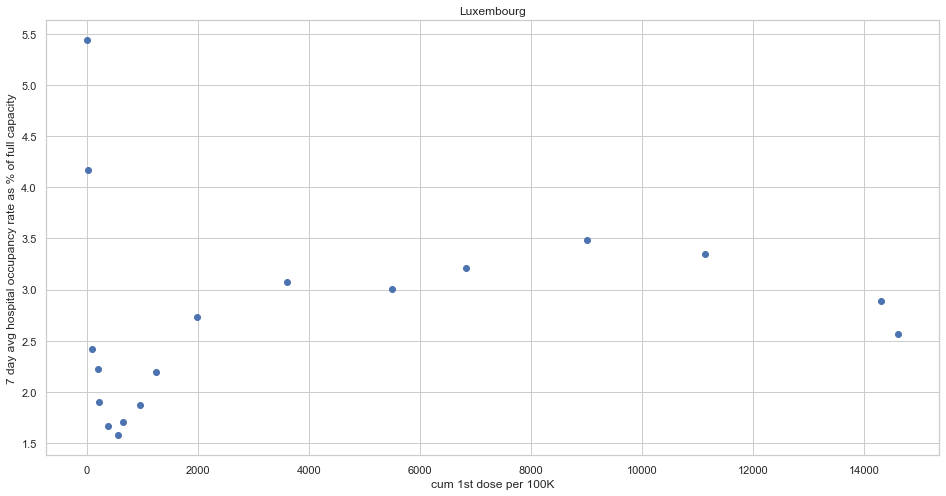

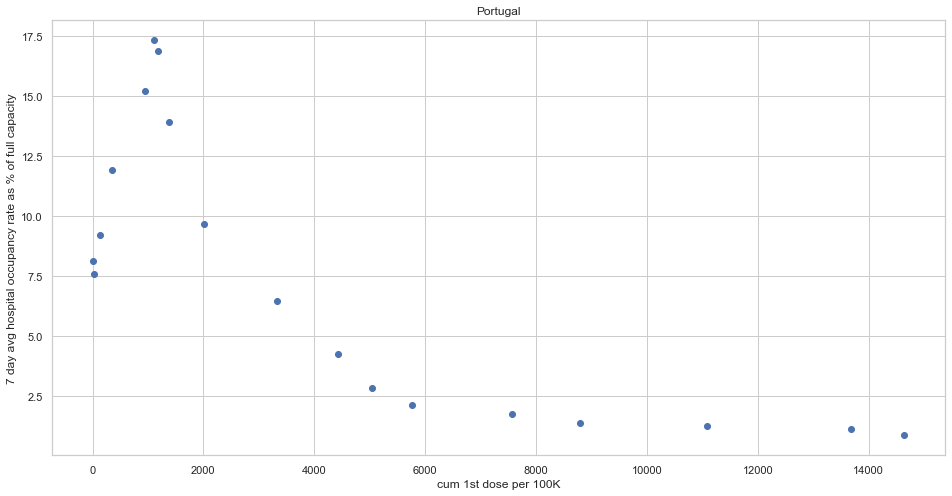

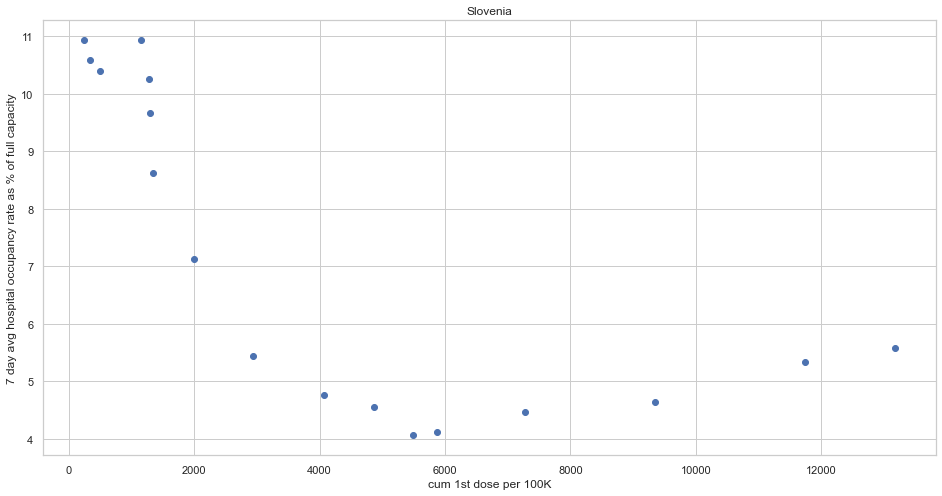

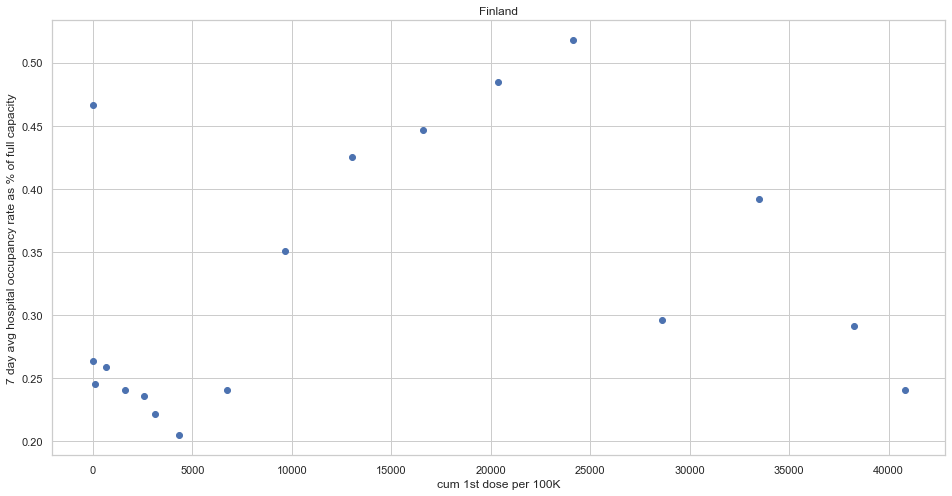

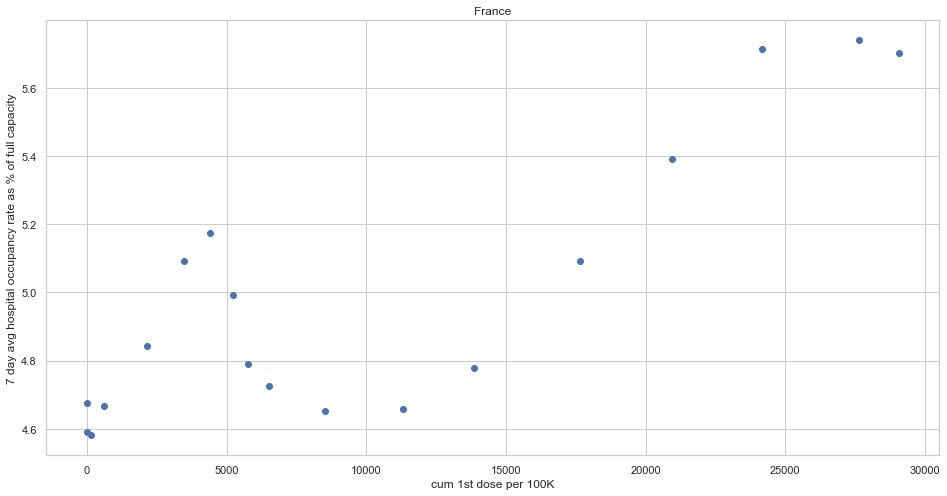

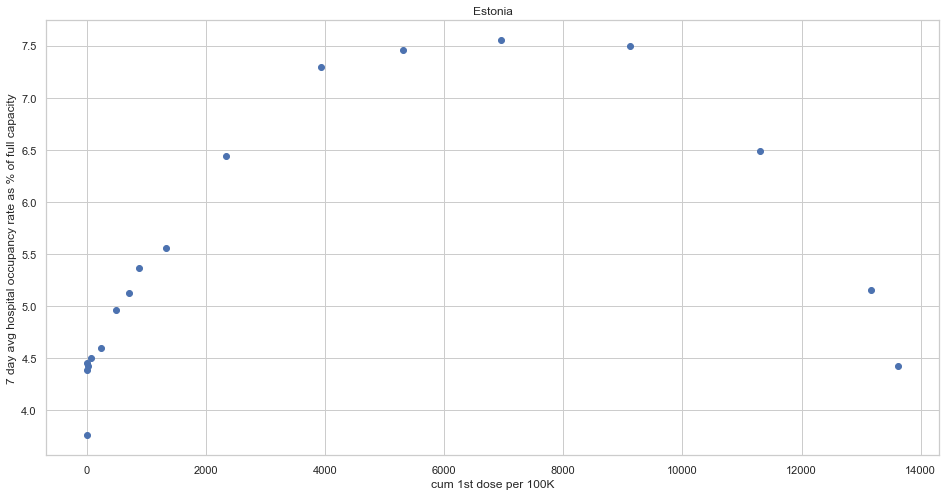

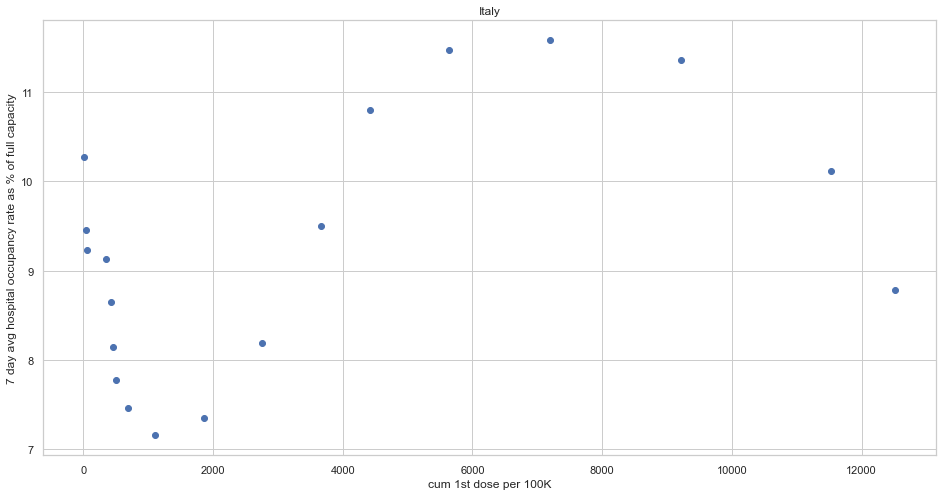

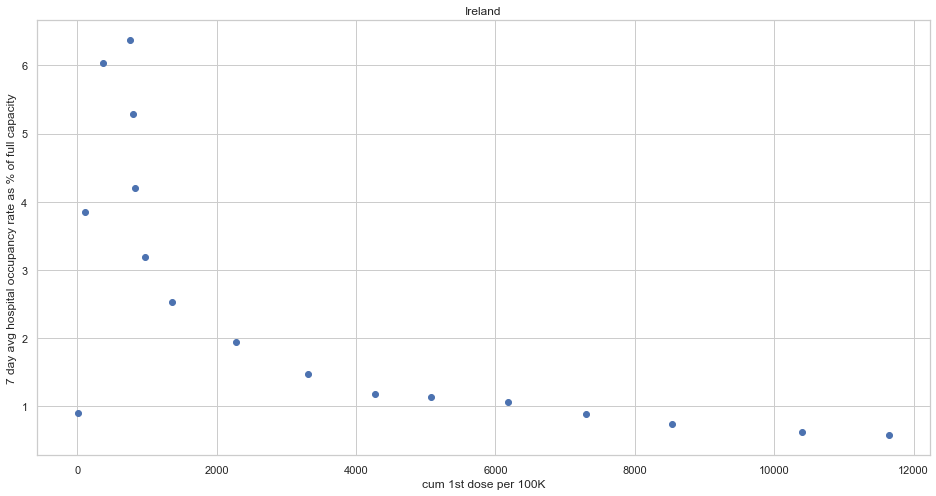

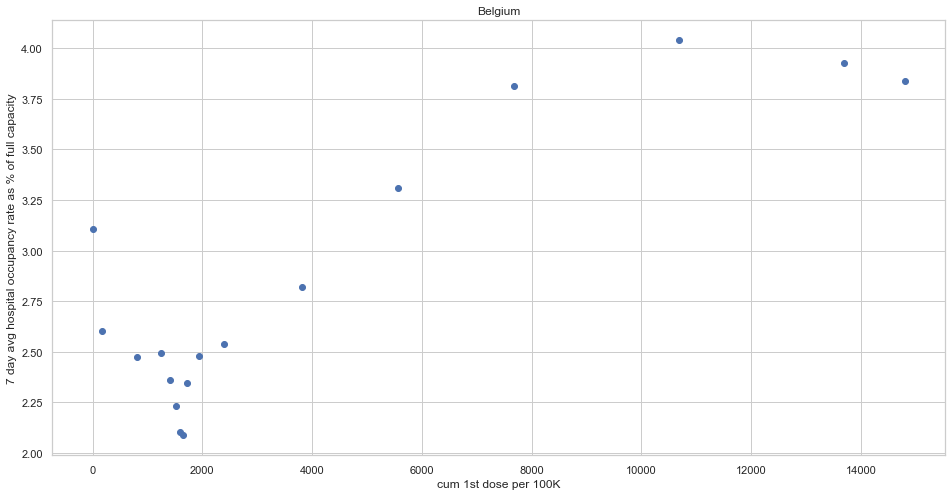

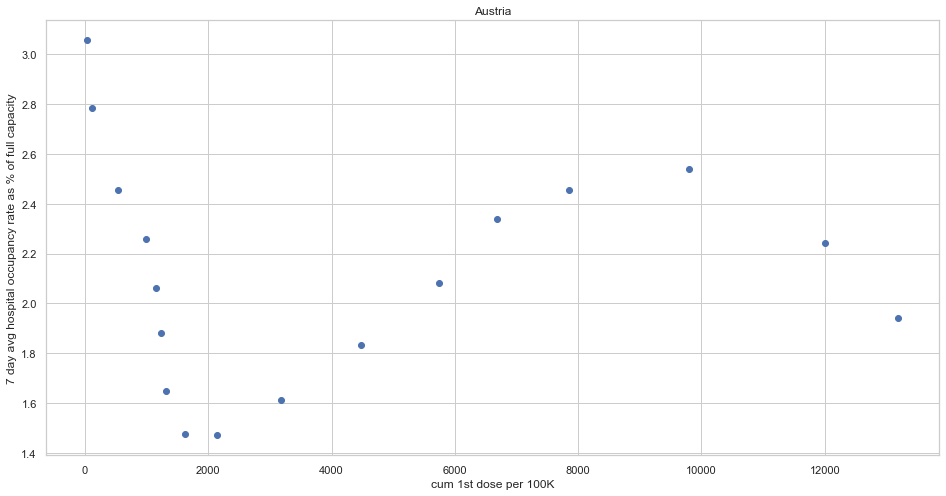

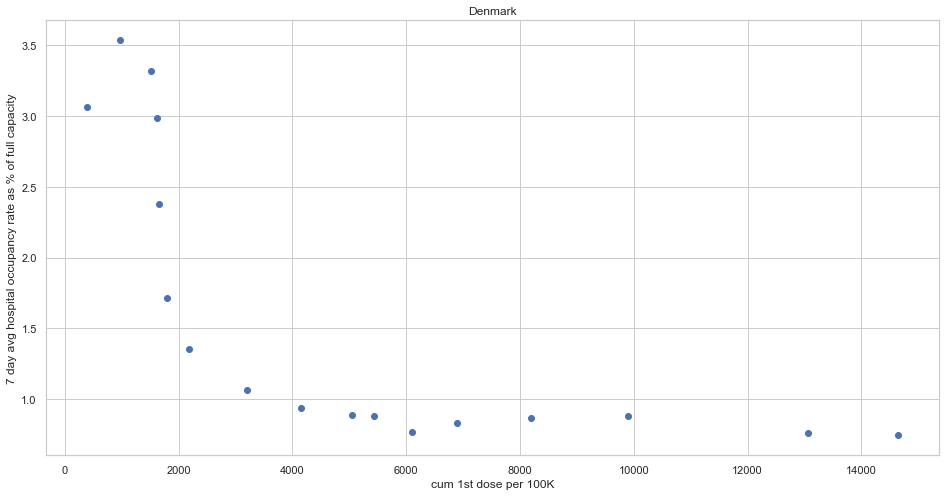

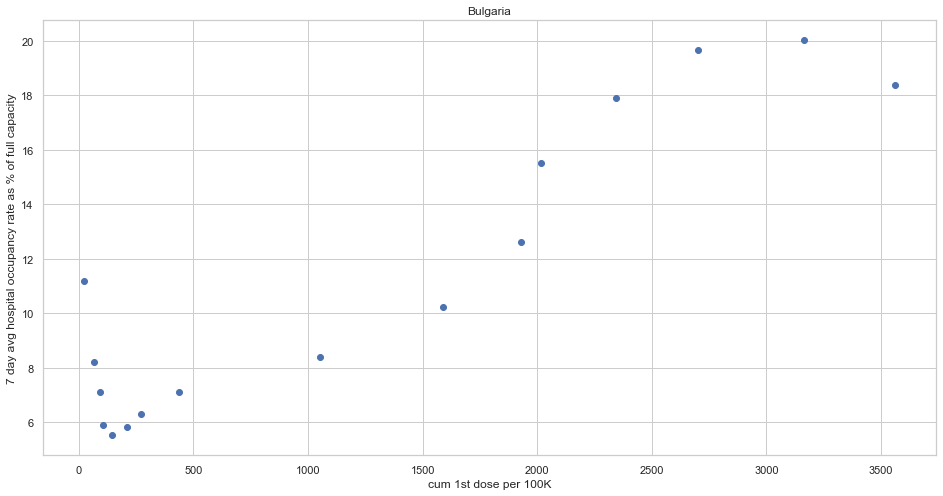

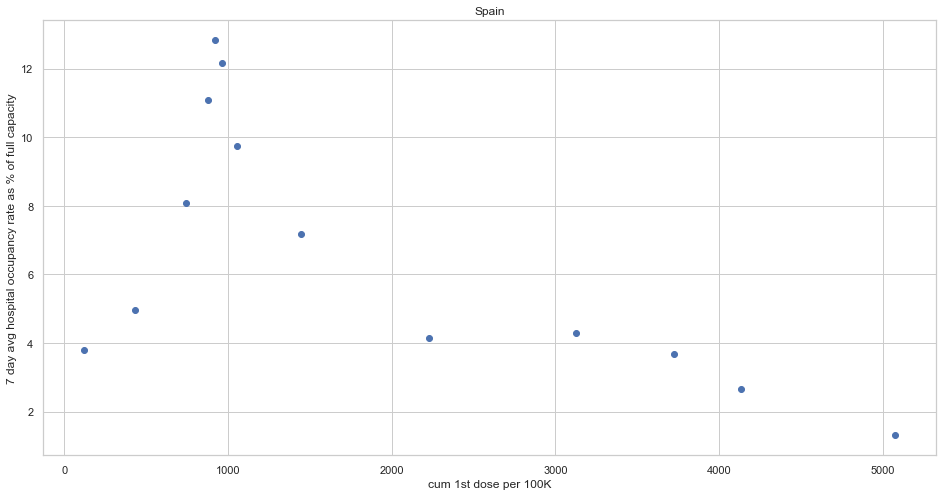

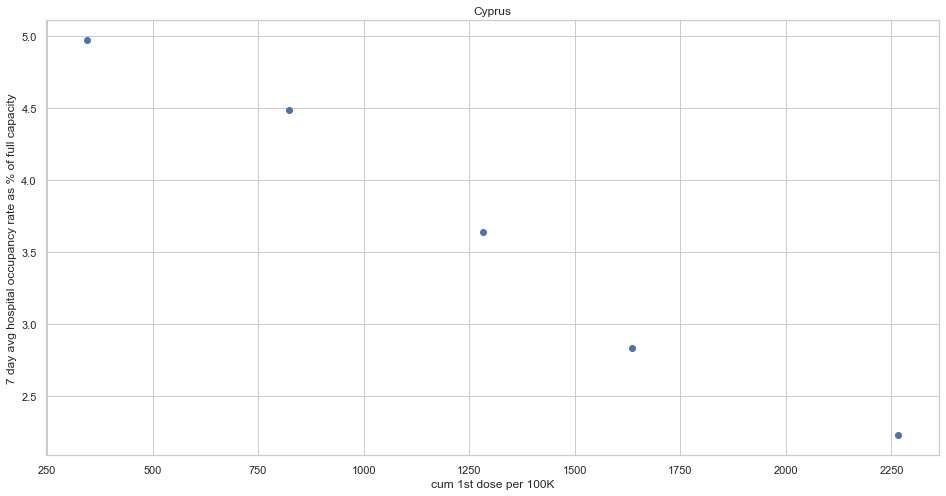

In [25]:
week_format_change=hospital_and_vax
week_format_change["year_week"]=hospital_and_vax["year_week"].replace(r'2020-', '', regex=True)
week_format_change["year_week"]=hospital_and_vax["year_week"].replace(r'2021-', '', regex=True)

unqCountries=hospital_and_vax["Country"].unique()
individualCountries=[]
for i in unqCountries:
    individualCountries.append(week_format_change[week_format_change["Country"]==i])
x_list=[]
y_list=[]

for i in individualCountries:
    #print(i["wkly ICU occupancy %"])
    x_list.append(i["cum 1st dose per 100K"])
    y_list.append(i["7 day avg hos oc %"])
    #print(i["year_week"]) #["Median Age"]) #["wkly ICU occupancy %"])
    #y=(i["14dDR"])
for t in range(len(x_list)):   
    plt.figure(figsize=(16, 8))
    plt.scatter(x_list[t],y_list[t])
    plt.title(unqCountries[t])
    plt.xlabel("cum 1st dose per 100K")
    plt.ylabel("7 day avg hospital occupancy rate as % of full capacity")
    plt.show()

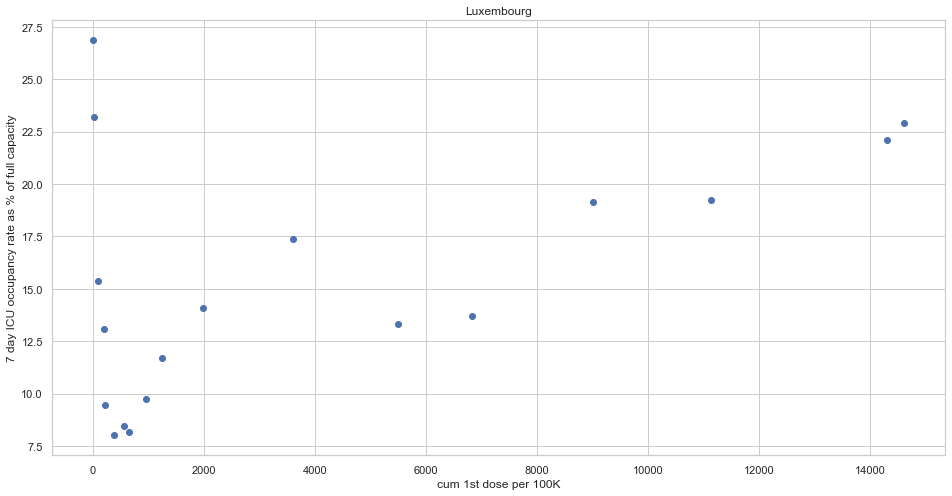

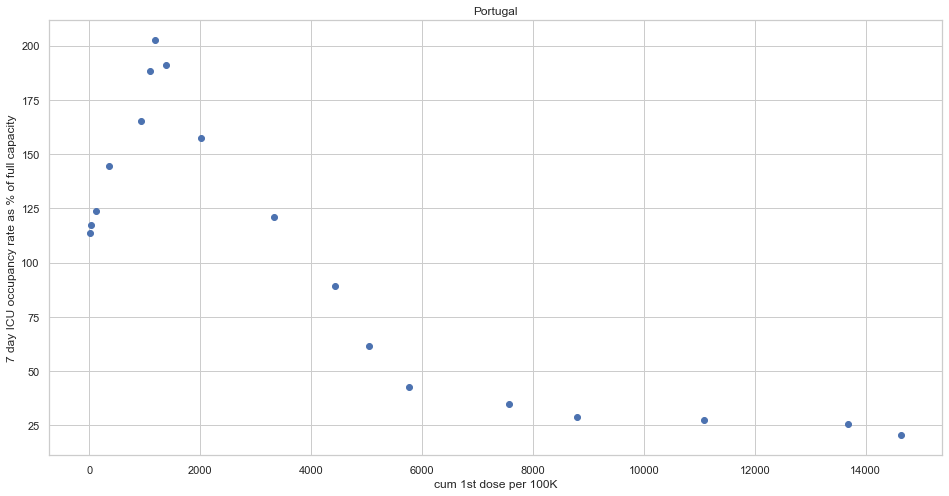

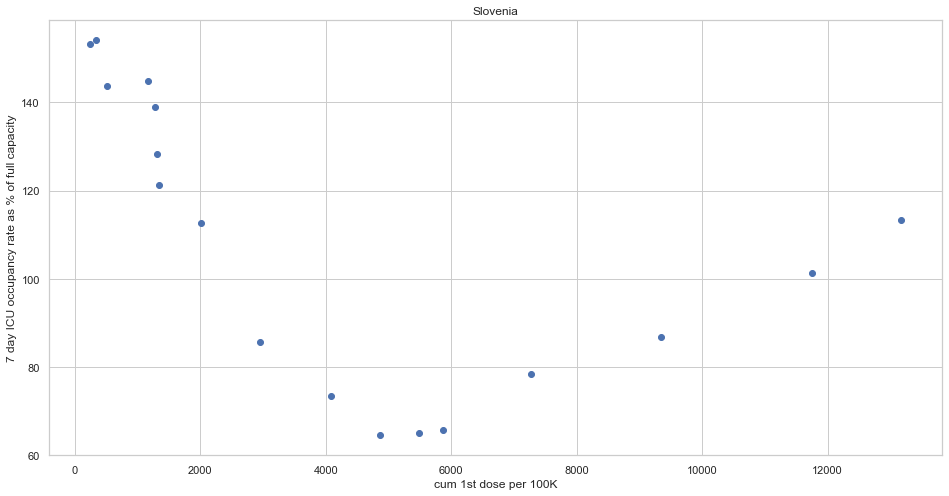

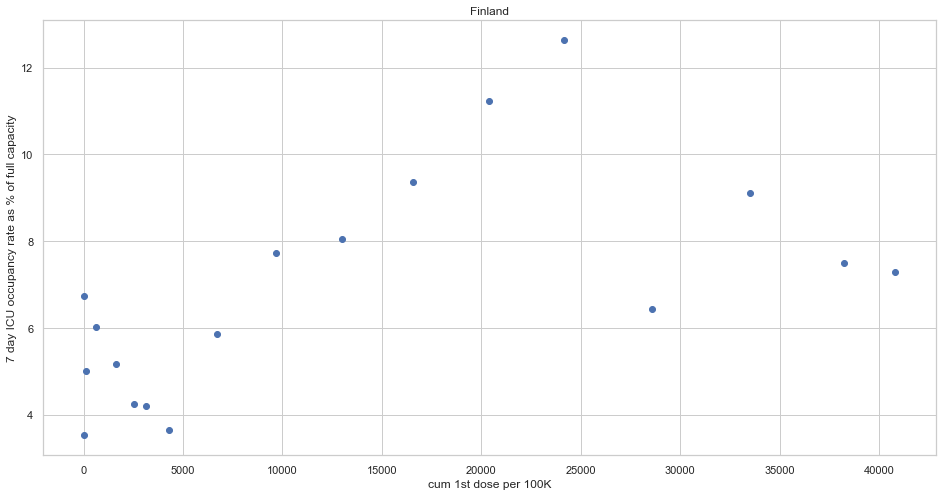

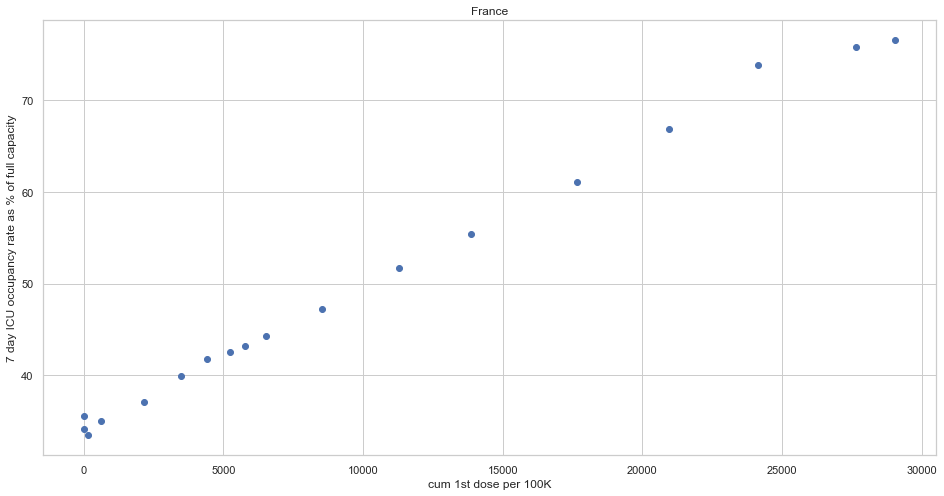

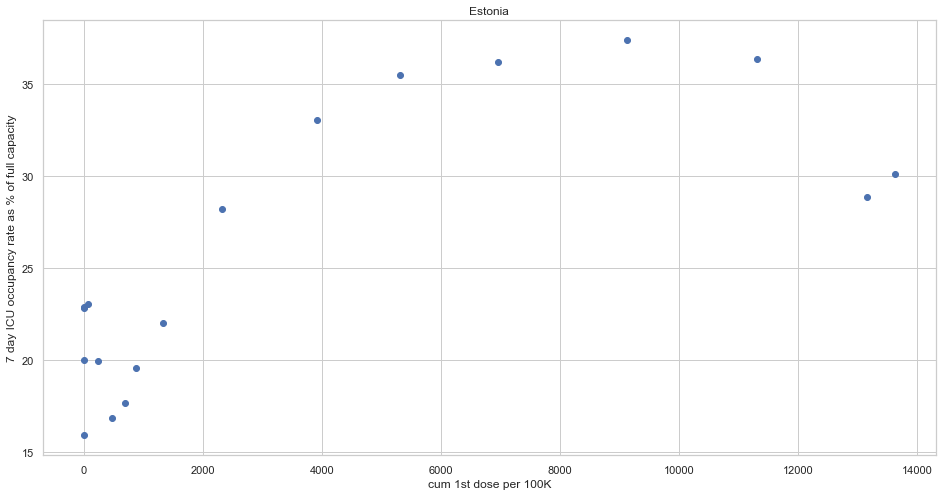

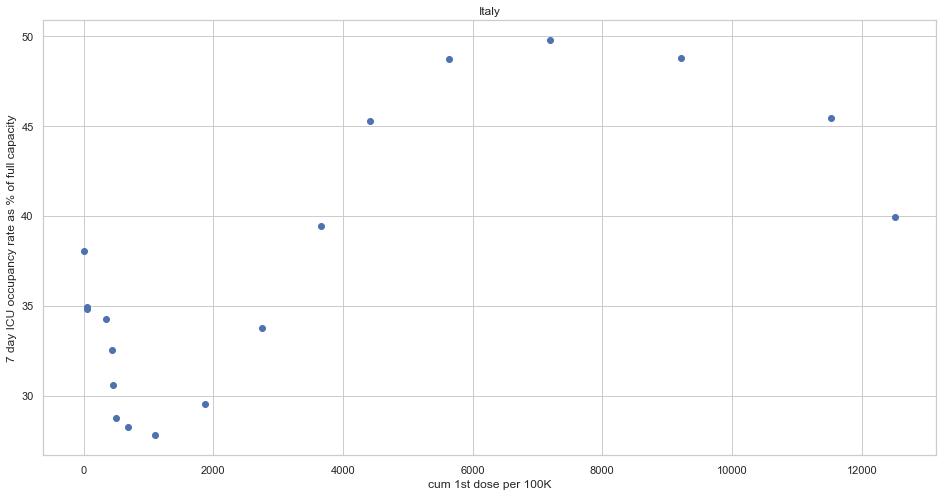

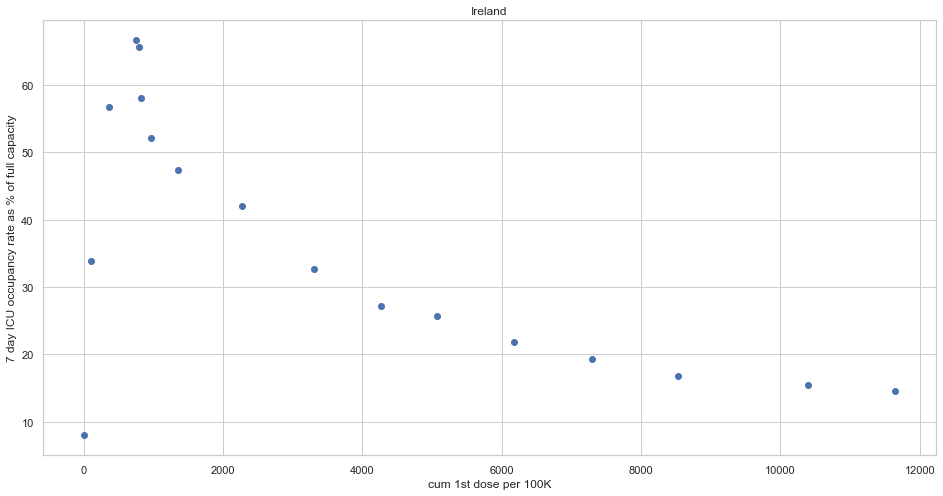

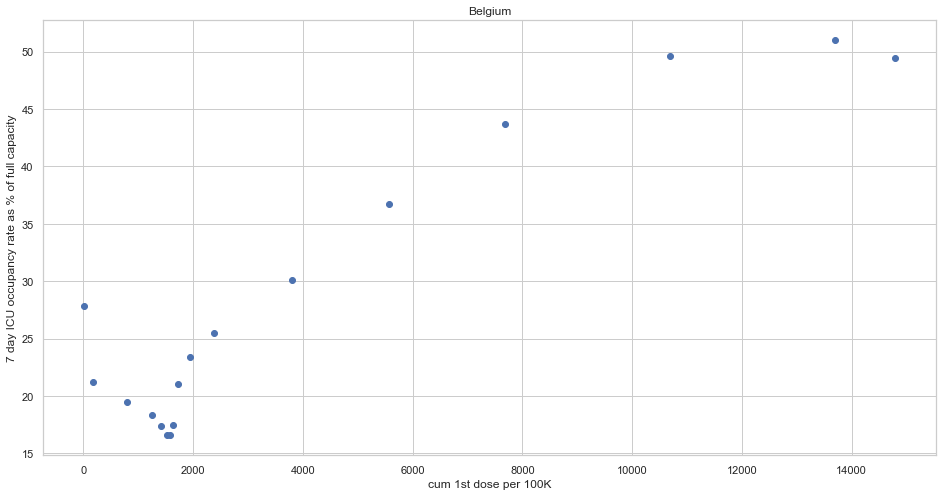

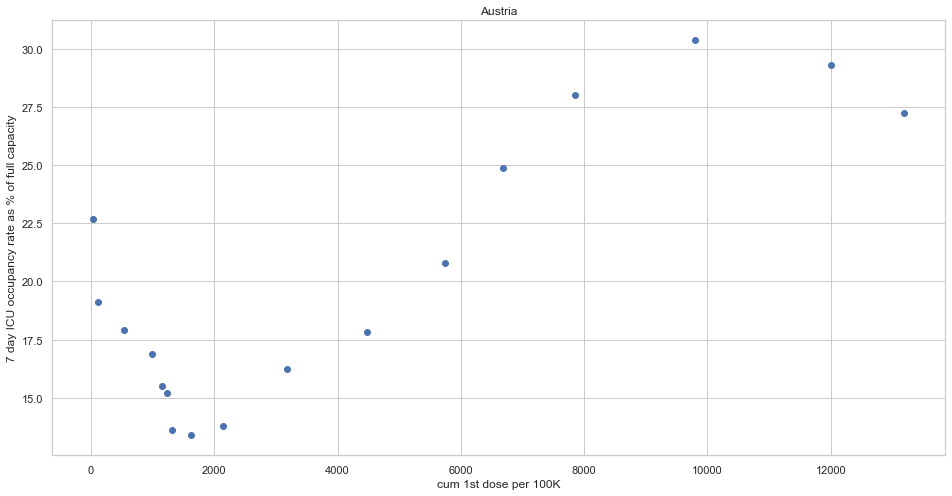

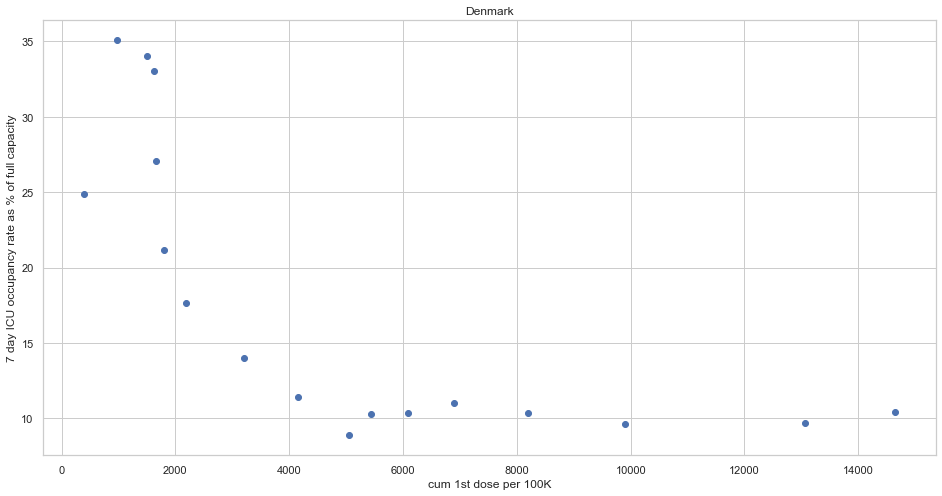

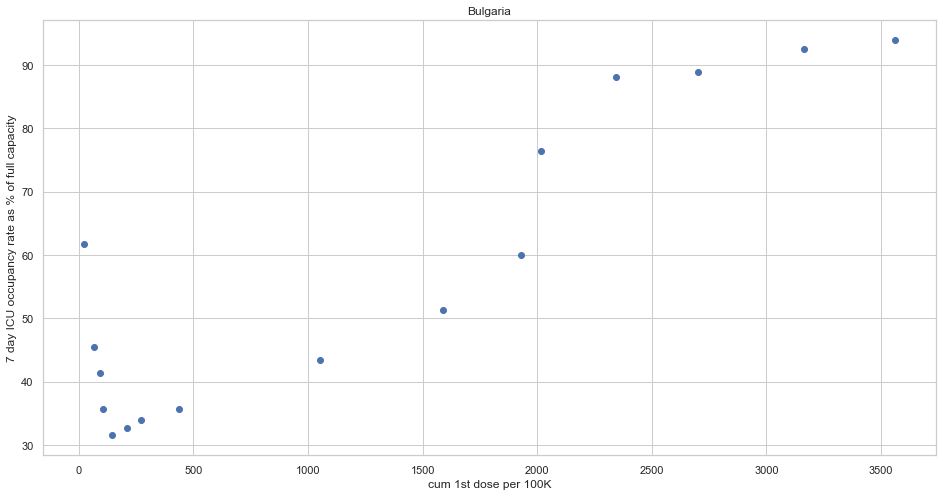

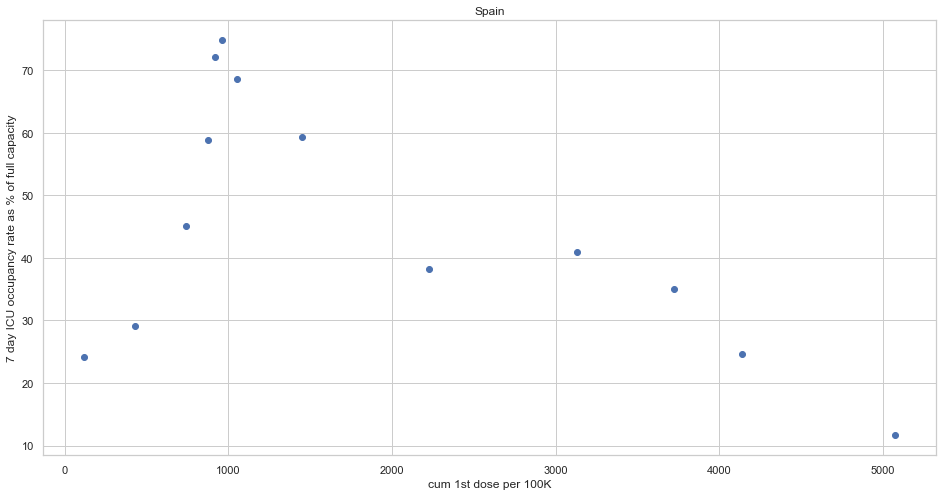

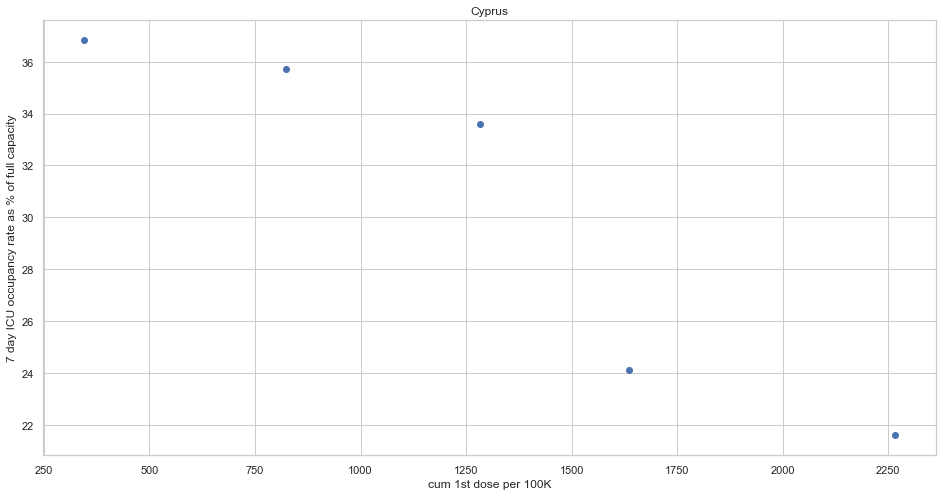

In [27]:
week_format_change=hospital_and_vax
week_format_change["year_week"]=hospital_and_vax["year_week"].replace(r'2020-', '', regex=True)
week_format_change["year_week"]=hospital_and_vax["year_week"].replace(r'2021-', '', regex=True)

unqCountries=hospital_and_vax["Country"].unique()
individualCountries=[]
for i in unqCountries:
    individualCountries.append(week_format_change[week_format_change["Country"]==i])
x_list=[]
y_list=[]

for i in individualCountries:
    #print(i["wkly ICU occupancy %"])
    x_list.append(i["cum 1st dose per 100K"])
    y_list.append(i["7 day avg ICU occupancy %"])
    #print(i["year_week"]) #["Median Age"]) #["wkly ICU occupancy %"])
    #y=(i["14dDR"])
for t in range(len(x_list)):   
    plt.figure(figsize=(16, 8))
    plt.scatter(x_list[t],y_list[t])
    plt.title(unqCountries[t])
    plt.xlabel("cum 1st dose per 100K")
    plt.ylabel("7 day ICU occupancy rate as % of full capacity")
    plt.show()

It is quite evident that vaccination rates have a very positive impact in terms of reducing hospitalisation rates and case fatality rate. It can be seen in some graphs that some countries (Bulgaria for example) has experienced a rise in hospital and ICU rates even as the cumulative vaccine dosage has increased. This may be due to other factors however such as a rise countries experiencing another wave of cases.